# POS Tagging System for English Text

## Introduction

Part-of-Speech (POS) tagging is a crucial task in Natural Language Processing (NLP), responsible for classifying words in a text into grammatical categories such as nouns, verbs, adjectives, etc. POS tagging serves as a foundation for many downstream NLP tasks such as syntactic parsing, named entity recognition, and even machine translation. 

In this notebook, we will build a POS tagging system based on the **Universal Dependencies English Web Treebank (UD-EWT)** dataset, which provides richly annotated data that makes this kind of analysis possible. We will use this dataset to preprocess, explore, and train multiple models to understand and classify the roles of words within sentences.

The dataset includes:
- **Textual data** with linguistic annotations like Universal Part of Speech (UPOS) tags and Language Specific Part of Speech (XPOS) tags.
- **Dependency Relations** providing information on the structure of sentences.

Our objective is to clean, preprocess, analyze, and build models to accurately predict POS tags for unseen text.

## Motivation

Understanding grammatical structures through POS tagging is essential to move towards more advanced NLP tasks. Proper POS tagging helps in understanding relationships between words, thereby improving language models and ultimately the performance of applications like chatbots, sentiment analysis, and machine translation.

This project is specifically valuable for exploring the applicability of POS tagging models, comparing their performance, and learning from the nuances of linguistic data. It also forms a basis for evaluating how well simpler, rule-based models perform compared to machine learning-based approaches.

## Objectives

This notebook aims to guide you through the entire journey, from data preprocessing to model evaluation. Specifically, we will:
- **Phase A**: Load, clean, and explore the dataset.
- **Phase B**: Develop baseline models for POS tagging and evaluate them.
- **Phase C**: Enhance the feature extraction and train/optimize model.
- **Phase D**: Analyze model performances and draw meaningful conclusions.

### Structure

- **Data Cleaning & Preprocessing**: We'll take raw annotated data and prepare it for analysis.
- **Exploratory Data Analysis (EDA)**: Gain insights into the distribution of POS tags and sentence structures.
- **Baseline Models**: Build simple baselines using Most Frequent Tag (MFT) and Hidden Markov Models (HMM).
- **Feature Extraction & Training**: Extract relevant features and train advanced models like Conditional Random Fields (CRF).
- **Evaluation**: Evaluate the effectiveness of these models on different parts of the dataset.

Throughout this project, we will document our thought process, challenges, and key findings clearly, allowing you to follow along easily.


### **Step 1: Downloading Required Dependencies**

Before we dive into the implementation of our POS tagging system, we need to ensure that all necessary libraries and tools are installed. This step involves:

- **Installing Libraries**: We will install essential libraries for data processing, machine learning, and natural language processing. Some of these libraries include:
    - `pandas` and `numpy` for data manipulation and numerical operations.
    - `matplotlib` and `seaborn` for data visualization.
    - `scikit-learn` for machine learning utilities.
    - `nltk` for natural language processing tasks.
    - `conllu` for parsing CoNLL-U formatted files.
    - `sklearn-crfsuite` for training Conditional Random Fields (CRF) models.

- **Setting Up the Environment**: We will configure our environment to ensure smooth execution of the notebook, minimizing the risk of compatibility or dependency issues later on.

Below are the commands to install the required dependencies:

In [1]:
#Install Imports
import subprocess
import sys

# Function to install a package using pip
def install_package(package):
    subprocess.check_call([sys.executable, "-m", "pip", "install", package])

# List of required packages
required_packages = [
    "pandas",
    "numpy",
    "conllu",
    "matplotlib",
    "seaborn",
    "scikit-learn",
    "sklearn-crfsuite",
    "nltk",
    "pyyaml",
    "requests"
]

# Check and install each package
for package in required_packages:
    try:
        __import__(package)
    except ImportError:
        print(f"Installing {package}...")
        install_package(package)


# Specialized NLP library
import nltk  # Natural Language Toolkit for NLP tasks
nltk.download('punkt')  # Ensure basic NLTK package for tokenization

Installing scikit-learn...
Installing sklearn-crfsuite...
Installing pyyaml...


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\sieul\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

### **Step 2: Setting Up Imports and Environment**

To effectively work on our Part of Speech (POS) tagging system, it's crucial we set up all necessary libraries and tools from the start. This step includes:

- **Importing Libraries**: We bring in important libraries for data processing, machine learning, plotting, and more. Each library plays a unique role:
  - **Data handling**: We use `pandas` for managing and manipulating our dataset, and `numpy` for numerical operations that will assist in our feature engineering.
  - **Visualization**: Libraries like `matplotlib` and `seaborn` will help us create insightful visualizations to understand our data.
  - **Machine Learning & NLP**: We bring in key machine learning utilities from `scikit-learn` for model training and evaluation, and `nltk` for natural language processing tasks like tokenization.
  - **Utilities**: Tools like `yaml` and our custom logging utility (`get_logger`) help streamline configuration management and logging, respectively.

- **Configuration File**: We load project configurations from `config.yaml`. This configuration file serves as a centralized location for storing paths and parameters, making it easier to maintain consistency across different scripts.

- **Logging Setup**: We establish a logger to keep track of activities. This helps not only in debugging but also in keeping a clean record of every processing step, which is essential for maintaining transparency during the project.

By setting up our imports and environment early on, we are ensuring that the notebook runs smoothly, minimizing the risk of running into compatibility or dependency issues later.


In [2]:
# Step 2: Setting Up Imports and Configurations

# Data handling and preprocessing libraries
import pandas as pd  # For data manipulation and analysis
import numpy as np  # For numerical operations
from conllu import parse_incr
# Standardizing punctuation (if needed)
import string

from collections import defaultdict, Counter
import math

# Visualization libraries
import matplotlib.pyplot as plt  # For plotting graphs and visualizations
import seaborn as sns  # High-level data visualization library built on matplotlib

# Machine learning libraries
from sklearn.model_selection import train_test_split  # For splitting the dataset into training and testing
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix  # Evaluation metrics
import sklearn_crfsuite
from sklearn_crfsuite import metrics
from sklearn_crfsuite import CRF
from sklearn.model_selection import train_test_split

# Logging utilities (using the custom logger)
from src.logging_utils import get_logger

# Configuration utilities
import yaml  # For loading configurations from config.yaml

# File operations and system tools
import os  # For file handling and working with file paths
import requests 

# Step 2.1: Load configuration
config_path = os.path.join('config', 'config.yaml')
with open(config_path, 'r') as file:
    config = yaml.safe_load(file)

# Step 2.2: Setting up the logger
logger = get_logger(__name__)

logger.info("All necessary libraries successfully imported and environment is set up.")



INFO - All necessary libraries successfully imported and environment is set up.


### **Step 3: Loading and Preparing the Dataset**

In this step, we ensure that the `.conllu` files required for our POS tagging system are available. If the files are missing, they are downloaded automatically. Once downloaded, these `.conllu` files are parsed into DataFrames to be used for subsequent steps.

- **3.1: Downloading Dataset Files**:
    - If the `.conllu` files (train, validate, test) do not exist in the `data/raw/` directory, they are automatically downloaded from the Universal Dependencies repository.
    - This helps ensure the raw data is always accessible and up-to-date.

- **3.2: Parsing the `.conllu` Files**:
    - We use the `conllu` library to parse these files and convert them into pandas DataFrames.
    - Each split (train, validate, test) is parsed separately, and we retain the key columns we need for feature extraction and model training.


#### **Step Goals**:
- **Parse the `.conllu` data** to extract features like tokens, lemmas, UPOS tags, etc.
- **Convert** this parsed data into a pandas DataFrame for consistency.
- **Verify** that the parsed data is correctly aligned.

#### **Parsing Implementation**:
The following implementation applies these principles to parse our CoNLL-U files and convert them into a format suitable for further analysis. Detailed logging ensures reproducibility and easier debugging if issues arise.


In [3]:

# Define the URLs to download the UD dataset files if not present
DATASET_URLS = {
    "train": "https://github.com/UniversalDependencies/UD_English-EWT/raw/r2.11/en_ewt-ud-train.conllu",
    "dev": "https://github.com/UniversalDependencies/UD_English-EWT/raw/r2.11/en_ewt-ud-dev.conllu",
    "test": "https://github.com/UniversalDependencies/UD_English-EWT/raw/r2.11/en_ewt-ud-test.conllu"
}

# Path to store raw data files
RAW_DATA_PATH = "data"

# Step 3.1: Downloading the Dataset Files if Missing
def download_dataset_files():
    if not os.path.exists(RAW_DATA_PATH):
        os.makedirs(RAW_DATA_PATH)
    for split, url in DATASET_URLS.items():
        file_path = os.path.join(RAW_DATA_PATH, f"en_ewt-ud-{split}.conllu")
        if not os.path.exists(file_path):
            try:
                logger.info(f"Downloading {split} dataset...")
                response = requests.get(url)
                response.raise_for_status()
                with open(file_path, 'wb') as f:
                    f.write(response.content)
                logger.info(f"Successfully downloaded {split} dataset to {file_path}")
            except requests.RequestException as e:
                logger.error(f"Failed to download {split} dataset: {e}")

# Step 3.2: Parsing the `.conllu` Files
def parse_conllu_file(file_path):
    """
    Parse a CoNLL-U formatted file and convert it into a DataFrame.
    
    Parameters:
    - file_path: Path to the .conllu file to be parsed.

    Returns:
    - A DataFrame with extracted data.
    """
    parsed_data = []

    try:
        with open(file_path, "r", encoding="utf-8") as f:
            for rowlist in parse_incr(f):
                tokens = [row["form"] for row in rowlist if row["form"] is not None]
                lemmas = [row["lemma"] for row in rowlist if row["lemma"] is not None]
                upos = [row["upostag"] for row in rowlist if row["upostag"] is not None]
                features = [row["feats"] if row["feats"] is not None else '_' for row in rowlist]  # Assuming features are stored in the "feats" column

                # Append parsed data only if at least `tokens` and `upos` are present
                if tokens and upos and lemmas:
                    parsed_data.append({
                        "tokens": tokens,
                        "lemmas": lemmas,
                        "upos": upos,
                        "features": features
                    })
                else:
                    logger.warning(f"Skipping sentence due to missing tokens or upos tags.")

        # Convert parsed data to a DataFrame
        parsed_df = pd.DataFrame(parsed_data)
        logger.info(f"Successfully parsed {len(parsed_df)} sentences from {file_path}")
        return parsed_df

    except FileNotFoundError:
        logger.error(f"File not found: {file_path}")
        raise
    except Exception as e:
        logger.error(f"An error occurred during parsing: {str(e)}")
        raise

# Execute Step 3
try:
    # 3.1: Download dataset files
    download_dataset_files()

    # 3.2: Load and parse each dataset split
    train_file = os.path.join(RAW_DATA_PATH, "en_ewt-ud-train.conllu")
    validate_file = os.path.join(RAW_DATA_PATH, "en_ewt-ud-dev.conllu")
    test_file = os.path.join(RAW_DATA_PATH, "en_ewt-ud-test.conllu")

    logger.info("Parsing training dataset...")
    df_train = parse_conllu_file(train_file)
    logger.info("Training dataset parsed successfully.")

    logger.info("Parsing validation dataset...")
    df_validate = parse_conllu_file(validate_file)
    logger.info("Validation dataset parsed successfully.")

    logger.info("Parsing test dataset...")
    df_test = parse_conllu_file(test_file)
    logger.info("Test dataset parsed successfully.")
    
    # Example Output
    display(df_train.head(10))

except Exception as e:
    logger.error(f"An error occurred during dataset preparation: {str(e)}")



INFO - Parsing training dataset...
INFO - Successfully parsed 12544 sentences from data\en_ewt-ud-train.conllu
INFO - Training dataset parsed successfully.
INFO - Parsing validation dataset...
INFO - Successfully parsed 2001 sentences from data\en_ewt-ud-dev.conllu
INFO - Validation dataset parsed successfully.
INFO - Parsing test dataset...
INFO - Successfully parsed 2077 sentences from data\en_ewt-ud-test.conllu
INFO - Test dataset parsed successfully.


,tokens,lemmas,upos,features
0,"[Al, -, Zaman, :, American, forces, killed, Sh...","[Al, -, Zaman, :, American, force, kill, Shaik...","[PROPN, PUNCT, PROPN, PUNCT, ADJ, NOUN, VERB, ...","[{'Number': 'Sing'}, _, {'Number': 'Sing'}, _,..."
1,"[[, This, killing, of, a, respected, cleric, w...","[[, this, killing, of, a, respected, cleric, w...","[PUNCT, DET, NOUN, ADP, DET, ADJ, NOUN, AUX, A...","[_, {'Number': 'Sing', 'PronType': 'Dem'}, {'N..."
2,"[DPA, :, Iraqi, authorities, announced, that, ...","[DPA, :, Iraqi, authority, announce, that, the...","[PROPN, PUNCT, ADJ, NOUN, VERB, SCONJ, PRON, A...","[{'Number': 'Sing'}, _, {'Degree': 'Pos'}, {'N..."
3,"[Two, of, them, were, being, run, by, 2, offic...","[two, of, they, be, be, run, by, 2, official, ...","[NUM, ADP, PRON, AUX, AUX, VERB, ADP, NUM, NOU...","[{'NumForm': 'Word', 'NumType': 'Card'}, _, {'..."
4,"[The, MoI, in, Iraq, is, equivalent, to, the, ...","[the, MoI, in, Iraq, be, equivalent, to, the, ...","[DET, PROPN, ADP, PROPN, AUX, ADJ, ADP, DET, P...","[{'Definite': 'Def', 'PronType': 'Art'}, {'Num..."
5,"[The, third, was, being, run, by, the, head, o...","[the, third, be, be, run, by, the, head, of, a...","[DET, ADJ, AUX, AUX, VERB, ADP, DET, NOUN, ADP...","[{'Definite': 'Def', 'PronType': 'Art'}, {'Deg..."
6,"[You, wonder, if, he, was, manipulating, the, ...","[you, wonder, if, he, be, manipulate, the, mar...","[PRON, VERB, SCONJ, PRON, AUX, VERB, DET, NOUN...","[{'Case': 'Nom', 'Person': '2', 'PronType': 'P..."
7,"[The, cells, were, operating, in, the, Ghazali...","[the, cell, be, operate, in, the, Ghazaliyah, ...","[DET, NOUN, AUX, VERB, ADP, DET, PROPN, CCONJ,...","[{'Definite': 'Def', 'PronType': 'Art'}, {'Num..."
8,"[Although, the, announcement, was, probably, m...","[although, the, announcement, be, probably, ma...","[SCONJ, DET, NOUN, AUX, ADV, VERB, PART, VERB,...","[_, {'Definite': 'Def', 'PronType': 'Art'}, {'..."
9,"[It, reminds, me, too, much, of, the, ARVN, of...","[it, remind, I, too, much, of, the, ARVN, offi...","[PRON, VERB, PRON, ADV, ADV, ADP, DET, PROPN, ...","[{'Case': 'Nom', 'Gender': 'Neut', 'Number': '..."


### **Step 4 (Expanded): Dataset Cleaning Process**

To prepare our dataset effectively for feature engineering and model training, we go through multiple cleaning phases to ensure high data quality and consistency. Each cleaning phase is carefully designed to eliminate any data integrity issues and produce a clean and reliable dataset.

Below are the individual steps taken to achieve a robust dataset for our POS tagging system.

#### **4.1: Handling Missing Values**
We begin by ensuring that no columns contain `NaN` values. Rows containing any `NaN` values are removed, as they can disrupt subsequent steps.

#### **4.2: Removing Empty Tokens or Sentences**
Sentences that have no tokens or consist solely of punctuation do not provide useful context. These rows are removed.

#### **4.3: Ensuring Column Alignment**
Each row should have a consistent number of tokens, lemmas, UPOS tags, etc. This ensures that our features are well-aligned and ready for modeling.

#### **4.4: Normalizing and Standardizing Data**
We proceed to ensure uniform text formats where needed, such as converting punctuations into meaningful tags or ensuring case consistency when required.

#### **Cleaning Implementation**:
The following implementation applies these principles to clean our dataset. Detailed logging ensures reproducibility and easier debugging if issues arise.


#### 4.1: Handling Missing Values

Missing values in any of our columns can disrupt subsequent modeling steps. Therefore, it's critical to ensure that our dataset is free from `NaN` values before proceeding. In this substep, we drop all rows containing `NaN` values and log the number of rows removed, which provides transparency and helps identify possible data quality issues.


In [4]:
# Step 4.1: Handling Missing Values for Training, Validation, and Test Splits

# Log the start of missing value handling for all splits
logger.info("Starting missing value handling for training, validation, and test splits...")

# Function for handling missing values
def handle_missing_values(df, split_name):
    # Total rows before handling missing values
    logger.info(f"Total rows before removing NaN values in {split_name} split: {len(df)}")

    # Removing rows with NaN values
    df_cleaned = df.dropna()

    # Total rows after handling missing values
    logger.info(f"Total rows after removing NaN values in {split_name} split: {len(df_cleaned)}")

    return df_cleaned

# Apply missing value handling for all splits
df_train = handle_missing_values(df_train, "training")
df_validate = handle_missing_values(df_validate, "validation")
df_test = handle_missing_values(df_test, "test")

# Display a few rows after handling missing values for verification
df_train.head()

print(list(df_train['features'])[0][1])




INFO - Starting missing value handling for training, validation, and test splits...
INFO - Total rows before removing NaN values in training split: 12544
INFO - Total rows after removing NaN values in training split: 12544
INFO - Total rows before removing NaN values in validation split: 2001
INFO - Total rows after removing NaN values in validation split: 2001
INFO - Total rows before removing NaN values in test split: 2077
INFO - Total rows after removing NaN values in test split: 2077


_


#### 4.2: Removing Empty Tokens or Sentences

In this step, we remove any rows that contain empty tokens or sentences. Sentences with no valuable information provide no meaningful context for our POS tagging system and can hinder our model's performance. To achieve this, we filter out such rows and document how many were removed.


In [5]:
# Step 4.2: Removing Empty Tokens or Sentences for Training, Validation, and Test Splits

# Log the start of removing empty tokens or sentences for all splits
logger.info("Starting removal of empty tokens or sentences for training, validation, and test splits...")

# Function for removing empty tokens or sentences
def remove_empty_tokens_or_sentences(df, split_name):
    # Total rows before removal of empty tokens or sentences
    logger.info(f"Total rows before removing empty tokens or sentences in {split_name} split: {len(df)}")

    # Remove rows where tokens are empty
    df_cleaned = df[df['tokens'].str.len() > 0]

    # Total rows after removal of empty tokens or sentences
    logger.info(f"Total rows after removing empty tokens or sentences in {split_name} split: {len(df_cleaned)}")

    return df_cleaned

# Apply empty token removal for all splits
df_train = remove_empty_tokens_or_sentences(df_train, "training")
df_validate = remove_empty_tokens_or_sentences(df_validate, "validation")
df_test = remove_empty_tokens_or_sentences(df_test, "test")

# Display a few rows from the training set for verification
df_train.head()




INFO - Starting removal of empty tokens or sentences for training, validation, and test splits...
INFO - Total rows before removing empty tokens or sentences in training split: 12544
INFO - Total rows after removing empty tokens or sentences in training split: 12544
INFO - Total rows before removing empty tokens or sentences in validation split: 2001
INFO - Total rows after removing empty tokens or sentences in validation split: 2001
INFO - Total rows before removing empty tokens or sentences in test split: 2077
INFO - Total rows after removing empty tokens or sentences in test split: 2077


,tokens,lemmas,upos,features
0,"[Al, -, Zaman, :, American, forces, killed, Sh...","[Al, -, Zaman, :, American, force, kill, Shaik...","[PROPN, PUNCT, PROPN, PUNCT, ADJ, NOUN, VERB, ...","[{'Number': 'Sing'}, _, {'Number': 'Sing'}, _,..."
1,"[[, This, killing, of, a, respected, cleric, w...","[[, this, killing, of, a, respected, cleric, w...","[PUNCT, DET, NOUN, ADP, DET, ADJ, NOUN, AUX, A...","[_, {'Number': 'Sing', 'PronType': 'Dem'}, {'N..."
2,"[DPA, :, Iraqi, authorities, announced, that, ...","[DPA, :, Iraqi, authority, announce, that, the...","[PROPN, PUNCT, ADJ, NOUN, VERB, SCONJ, PRON, A...","[{'Number': 'Sing'}, _, {'Degree': 'Pos'}, {'N..."
3,"[Two, of, them, were, being, run, by, 2, offic...","[two, of, they, be, be, run, by, 2, official, ...","[NUM, ADP, PRON, AUX, AUX, VERB, ADP, NUM, NOU...","[{'NumForm': 'Word', 'NumType': 'Card'}, _, {'..."
4,"[The, MoI, in, Iraq, is, equivalent, to, the, ...","[the, MoI, in, Iraq, be, equivalent, to, the, ...","[DET, PROPN, ADP, PROPN, AUX, ADJ, ADP, DET, P...","[{'Definite': 'Def', 'PronType': 'Art'}, {'Num..."


#### 4.3: Ensuring Column Alignment

To ensure the integrity of our dataset, it's critical that each row has the correct number of tokens, lemmas, UPOS tags. A misalignment could negatively impact the feature extraction and modeling phases. We will verify that the length of each field matches across the dataset and correct any rows that do not comply.


In [6]:
# Step 4.3: Ensuring Column Alignment for Training, Validation, and Test Splits

# Log the start of column alignment for all splits
logger.info("Starting column alignment check for training, validation, and test splits...")

def ensure_column_alignment(df, split_name):
    """
    Ensure all rows in the DataFrame have consistent column lengths for tokens, lemmas, and upos.

    Parameters:
    - df: The pandas DataFrame to be checked.
    - split_name: Name of the split being processed (e.g., 'training').

    Returns:
    - df_aligned: A new DataFrame with only aligned rows.
    """
    # Log total rows before alignment check
    logger.info(f"Total rows before ensuring column alignment in {split_name} split: {len(df)}")
    
    # Identify rows with aligned column lengths
    def is_aligned(row):
        lengths = [len(row[col]) for col in ['tokens', 'lemmas', 'upos']]
        return all(length == lengths[0] for length in lengths)

    # Apply the alignment check
    df_aligned = df[df.apply(is_aligned, axis=1)]

    # Log details about rows with misalignment
    misaligned_indices = df[~df.apply(is_aligned, axis=1)].index
    for idx in misaligned_indices:
        row = df.loc[idx]
        logger.error(f"Misalignment found in row {idx}: tokens={len(row['tokens'])}, lemmas={len(row['lemmas'])}, upos={len(row['upos'])}")

    # Log total rows after alignment check
    logger.info(f"Total rows after ensuring column alignment in {split_name} split: {len(df_aligned)}")
    
    return df_aligned

# Apply column alignment for all splits
df_train = ensure_column_alignment(df_train, "training")
df_validate = ensure_column_alignment(df_validate, "validation")
df_test = ensure_column_alignment(df_test, "test")

# Display a few rows from the training set for verification
df_train.head()



INFO - Starting column alignment check for training, validation, and test splits...
INFO - Total rows before ensuring column alignment in training split: 12544
INFO - Total rows after ensuring column alignment in training split: 12544
INFO - Total rows before ensuring column alignment in validation split: 2001
INFO - Total rows after ensuring column alignment in validation split: 2001
INFO - Total rows before ensuring column alignment in test split: 2077
INFO - Total rows after ensuring column alignment in test split: 2077


,tokens,lemmas,upos,features
0,"[Al, -, Zaman, :, American, forces, killed, Sh...","[Al, -, Zaman, :, American, force, kill, Shaik...","[PROPN, PUNCT, PROPN, PUNCT, ADJ, NOUN, VERB, ...","[{'Number': 'Sing'}, _, {'Number': 'Sing'}, _,..."
1,"[[, This, killing, of, a, respected, cleric, w...","[[, this, killing, of, a, respected, cleric, w...","[PUNCT, DET, NOUN, ADP, DET, ADJ, NOUN, AUX, A...","[_, {'Number': 'Sing', 'PronType': 'Dem'}, {'N..."
2,"[DPA, :, Iraqi, authorities, announced, that, ...","[DPA, :, Iraqi, authority, announce, that, the...","[PROPN, PUNCT, ADJ, NOUN, VERB, SCONJ, PRON, A...","[{'Number': 'Sing'}, _, {'Degree': 'Pos'}, {'N..."
3,"[Two, of, them, were, being, run, by, 2, offic...","[two, of, they, be, be, run, by, 2, official, ...","[NUM, ADP, PRON, AUX, AUX, VERB, ADP, NUM, NOU...","[{'NumForm': 'Word', 'NumType': 'Card'}, _, {'..."
4,"[The, MoI, in, Iraq, is, equivalent, to, the, ...","[the, MoI, in, Iraq, be, equivalent, to, the, ...","[DET, PROPN, ADP, PROPN, AUX, ADJ, ADP, DET, P...","[{'Definite': 'Def', 'PronType': 'Art'}, {'Num..."


#### 4.4: Normalizing and Standardizing Data
We proceed to ensure uniform text formats where needed, such as converting punctuations into meaningful tags or ensuring case consistency when required.


In [7]:
# Step 4.4: Normalizing and Standardizing Data for Training, Validation, and Test Splits

# Log the start of normalization and standardization for all splits
logger.info("Starting normalization and standardization for training, validation, and test splits...")

def normalize_and_standardize(df, split_name):
    """
    Normalize and standardize the given DataFrame.

    Parameters:
    - df: A pandas DataFrame to normalize and standardize.
    - split_name: Name of the split being processed (e.g., 'training').

    Returns:
    - df: The updated DataFrame after normalization and standardization.
    """
    # Log the start of normalization for the given split
    logger.info(f"Starting normalization and standardization for {split_name} split...")

    # Remove leading/trailing spaces from tokens
    df['tokens'] = df['tokens'].apply(lambda tokens: [token.strip() for token in tokens])

    # Remove any empty tokens that may be left behind
    df['tokens'] = df['tokens'].apply(lambda tokens: [token for token in tokens if token != ''])

    # Standardizing UPOS tags
    upos_standard_set = set(['ADJ', 'ADP', 'ADV', 'AUX', 'CCONJ', 'DET', 'INTJ', 'NOUN', 'NUM', 'PART', 'PRON', 'PROPN', 'PUNCT', 'SCONJ', 'SYM', 'VERB', 'X'])
    df['upos'] = df['upos'].apply(lambda upos_tags: [tag if tag in upos_standard_set else 'X' for tag in upos_tags])

    # Handle URLs and Emails by standardizing them to placeholder tokens
    def normalize_special_tokens(tokens):
        normalized_tokens = []
        for token in tokens:
            if "@" in token:
                normalized_tokens.append('<EMAIL>')
            elif token.startswith("http"):
                normalized_tokens.append('<URL>')
            else:
                normalized_tokens.append(token)
        return normalized_tokens

    df['tokens'] = df['tokens'].apply(normalize_special_tokens)

    # Log the successful completion of normalization for the given split
    logger.info(f"Normalization and standardization completed successfully for {split_name} split.")
    
    return df

# Apply normalization and standardization to all splits
df_train = normalize_and_standardize(df_train, "training")
df_validate = normalize_and_standardize(df_validate, "validation")
df_test = normalize_and_standardize(df_test, "test")

# Display a few rows from the training set for verification
df_train.head()


INFO - Starting normalization and standardization for training, validation, and test splits...
INFO - Starting normalization and standardization for training split...
INFO - Normalization and standardization completed successfully for training split.
INFO - Starting normalization and standardization for validation split...
INFO - Normalization and standardization completed successfully for validation split.
INFO - Starting normalization and standardization for test split...
INFO - Normalization and standardization completed successfully for test split.


,tokens,lemmas,upos,features
0,"[Al, -, Zaman, :, American, forces, killed, Sh...","[Al, -, Zaman, :, American, force, kill, Shaik...","[PROPN, PUNCT, PROPN, PUNCT, ADJ, NOUN, VERB, ...","[{'Number': 'Sing'}, _, {'Number': 'Sing'}, _,..."
1,"[[, This, killing, of, a, respected, cleric, w...","[[, this, killing, of, a, respected, cleric, w...","[PUNCT, DET, NOUN, ADP, DET, ADJ, NOUN, AUX, A...","[_, {'Number': 'Sing', 'PronType': 'Dem'}, {'N..."
2,"[DPA, :, Iraqi, authorities, announced, that, ...","[DPA, :, Iraqi, authority, announce, that, the...","[PROPN, PUNCT, ADJ, NOUN, VERB, SCONJ, PRON, A...","[{'Number': 'Sing'}, _, {'Degree': 'Pos'}, {'N..."
3,"[Two, of, them, were, being, run, by, 2, offic...","[two, of, they, be, be, run, by, 2, official, ...","[NUM, ADP, PRON, AUX, AUX, VERB, ADP, NUM, NOU...","[{'NumForm': 'Word', 'NumType': 'Card'}, _, {'..."
4,"[The, MoI, in, Iraq, is, equivalent, to, the, ...","[the, MoI, in, Iraq, be, equivalent, to, the, ...","[DET, PROPN, ADP, PROPN, AUX, ADJ, ADP, DET, P...","[{'Definite': 'Def', 'PronType': 'Art'}, {'Num..."


# **PHASE B** 

### **Step B1: Most Frequent Tag (MFT) Baseline Model**

In this section, we implement our first baseline model for Part-of-Speech (POS) tagging: the **Most Frequent Tag (MFT)** model.

#### **Concept**:
The MFT model assigns each word its most common POS tag observed in the training data. If the word has not been seen during training, it assigns the tag with the highest overall frequency. This simple approach gives us a foundational baseline to compare against more advanced models.

#### **Goal**:
- To compute the most frequent POS tag for each word in our **training dataset**.
- Store this mapping in a **lookup dictionary**.
- Use the lookup dictionary to tag words in the **validation** and **test** datasets.
  
This helps us set a benchmark accuracy for POS tagging, allowing us to later assess how much improvement more advanced models offer.


In [8]:
import collections
from sklearn.metrics import accuracy_score

# Step B1.1: Computing the Most Frequent Tag for Each Word in the Training Data
logger.info("Computing the Most Frequent Tag for each word in the training data...")

# Initialize an empty dictionary to store tag counts for each word
word_tag_counts = collections.defaultdict(lambda: collections.defaultdict(int))

# Traverse the training dataset to compute the counts
for _, row in df_train.iterrows():
    tokens = row['tokens']
    upos_tags = row['upos']
    
    # Ensure that tokens and upos_tags are aligned
    if len(tokens) != len(upos_tags):
        logger.warning(f"Skipping row with misaligned tokens and tags: tokens={len(tokens)}, tags={len(upos_tags)}")
        continue

    for token, upos_tag in zip(tokens, upos_tags):
        word_tag_counts[token][upos_tag] += 1

# Create the final lookup dictionary by selecting the most frequent tag for each word
word_to_mft = {word: max(tags, key=tags.get) for word, tags in word_tag_counts.items()}

# Step B1.2: Tagging New Sentences Using the MFT Lookup Dictionary

def mft_tag_sentence(tokens, word_to_mft, default_tag='NOUN'):
    """
    Tag a list of tokens using the Most Frequent Tag (MFT) model.
    
    Parameters:
    - tokens: List of tokens in a sentence.
    - word_to_mft: Dictionary mapping words to their most frequent tags.
    - default_tag: Tag to use for unknown words (default: 'NOUN').
    
    Returns:
    - List of predicted tags.
    """
    # Check if the tokens list is empty
    if not tokens:
        logger.warning("Received an empty tokens list for tagging. Returning empty predicted tags.")
        return []

    # Generate predicted tags using the MFT model
    predicted_tags = [word_to_mft.get(token, default_tag) for token in tokens]

    # Ensure that predicted_tags is always a list
    if not isinstance(predicted_tags, list):
        logger.error("Predicted tags is not a list. Returning an empty list instead.")
        return []

    return predicted_tags

# Step B1.3: Evaluate MFT Model on Validation and Test Data
logger.info("Evaluating the MFT model on validation and test data splits...")

def evaluate_mft_model(df, word_to_mft):
    """
    Evaluate the MFT model on a given dataset split.
    
    Parameters:
    - df: DataFrame containing the dataset split (validation or test).
    - word_to_mft: Dictionary mapping words to their most frequent tags.
    
    Returns:
    - Accuracy of the MFT model on the given dataset.
    """
    all_true_tags = []
    all_predicted_tags = []

    for _, row in df.iterrows():
        tokens = row['tokens']
        true_tags = row['upos']

        # Ensure that tokens and true_tags are aligned
        if len(tokens) != len(true_tags):
            logger.warning(f"Skipping row with misaligned tokens and true_tags: tokens={len(tokens)}, true_tags={len(true_tags)}")
            continue

        # Predict tags using the MFT model
        predicted_tags = mft_tag_sentence(tokens, word_to_mft)

        # Ensure predicted_tags is a list (sanity check)
        if predicted_tags is None:
            logger.error(f"Predicted tags is None for tokens: {tokens}. Skipping this row.")
            continue

        # Append true and predicted tags for evaluation
        all_true_tags.extend(true_tags)
        all_predicted_tags.extend(predicted_tags)

    # Logging the length of the true and predicted tags for debugging
    logger.info(f"Total true tags: {len(all_true_tags)}, Total predicted tags: {len(all_predicted_tags)}")

    # Ensure both lists are of the same length
    if len(all_true_tags) != len(all_predicted_tags):
        logger.error(f"Mismatch in length: true_tags={len(all_true_tags)}, predicted_tags={len(all_predicted_tags)}")
        raise ValueError(f"Mismatch in length between true and predicted tags: true_tags={len(all_true_tags)}, predicted_tags={len(all_predicted_tags)}")

    # Calculate and return accuracy
    return accuracy_score(all_true_tags, all_predicted_tags)

# Evaluate the MFT model on the validation and test sets
try:
    logger.info("Evaluating MFT model on validation set...")
    mft_validation_accuracy = evaluate_mft_model(df_validate, word_to_mft)
    
    logger.info("Evaluating MFT model on test set...")
    mft_test_accuracy = evaluate_mft_model(df_test, word_to_mft)
    
    logger.info(f"Validation Accuracy (MFT Model): {mft_validation_accuracy:.2f}")
    logger.info(f"Test Accuracy (MFT Model): {mft_test_accuracy:.2f}")

except ValueError as e:
    logger.error(f"Error during MFT model evaluation: {e}")


INFO - Computing the Most Frequent Tag for each word in the training data...
INFO - Evaluating the MFT model on validation and test data splits...
INFO - Evaluating MFT model on validation set...
INFO - Total true tags: 25512, Total predicted tags: 25512
INFO - Evaluating MFT model on test set...
INFO - Total true tags: 25451, Total predicted tags: 25451
INFO - Validation Accuracy (MFT Model): 0.86
INFO - Test Accuracy (MFT Model): 0.86


### **Step B1: Results and Analysis of the Most Frequent Tag (MFT) Baseline Model**

#### **Results**:
After implementing the MFT model, we evaluated it on both the validation and test datasets. Below are the results:

- **Validation Accuracy**: This gives us an idea of how well the model generalizes to unseen data that wasn't used during training.
- **Test Accuracy**: The performance of the model on truly unseen data, which represents real-world scenarios.

#### **Key Insights**:
- The **MFT model** is a very simple approach that relies purely on frequency. It provides a strong baseline for words that are common in the training set but struggles with **out-of-vocabulary** words as they would just be defaulted to the NOUN Tag. Additional reasons for incorrect predictions is due to the model's inability to fully capture the context surrounding the token being predicted.
- By comparing future models to this baseline, we can quantify how much we improve over a straightforward, frequency-based tagging approach.

The next steps will involve developing a more sophisticated baseline model, namely an **HMM-based tagger**, to see if probabilistic modeling of sequences can provide a significant boost in performance.


### Step B2: Hidden Markov Model (HMM) for POS Tagging

In this section, we are going to build a **Hidden Markov Model (HMM)** to tag parts of speech for our sentences. 

#### **What is an HMM?**
A **Hidden Markov Model** is a statistical model that assumes there is a system governed by hidden states which produce observable outputs. In the context of POS tagging, the hidden states are **POS tags** (e.g., NOUN, VERB, ADJ), and the observable outputs are the words in the sentence.

HMM models are useful for POS tagging as they can incorporate **dependencies between words** in a sequence, which allows for more accurate tagging compared to independent tagging models like the **Most Frequent Tag (MFT)** baseline.

#### **How does it work?**
- **States**: The POS tags are our states.
- **Observations**: The words are our observations.
- **Transition Probabilities**: These represent the probability of transitioning from one POS tag to another (e.g., the probability that a NOUN is followed by a VERB).
- **Emission Probabilities**: These represent the probability of a word being generated given a specific tag (e.g., the probability that the word 'run' is a VERB).
- **Initial State Probabilities**: The likelihood of each POS tag being the starting tag for a sentence.

To predict the tags for a new sentence, we'll use the **Viterbi algorithm**, which helps find the most probable sequence of hidden states (POS tags) given the observed sequence (the words in the sentence).

#### **What do we hope to achieve?**
The HMM model aims to achieve better accuracy than the MFT baseline by leveraging the relationships between adjacent words and their tags. This means we expect the HMM to perform significantly better, especially on sequences where context plays a crucial role in determining the correct POS tags.

In the following steps, we'll:
1. **Estimate the model parameters** (transition, emission, and initial probabilities).
2. **Train the model** using our training data.
3. **Evaluate** the model on validation and test sets to see if it improves over the MFT baseline.


In [9]:
# Step 2: Implementing the HMM Model

# Setting up the logger for this step
logger.info("Training the HMM POS tagging model...")

# 2.1: Estimating Transition, Emission, and Initial Probabilities

def estimate_hmm_parameters(df_train):
    """
    Estimate transition, emission, and initial probabilities from training data.

    Parameters:
    - df_train: A pandas DataFrame containing tokens, lemmas, and upos for training. 

    Returns:
    - transition_probs: A dictionary with transition probabilities between tags.
    - emission_probs: A dictionary with emission probabilities of words given tags.
    - initial_probs: A dictionary with initial state probabilities.
    """
    # Counter for initial probabilities
    initial_counts = Counter()
    
    # Counters for transitions and emissions
    transition_counts = defaultdict(Counter)
    emission_counts = defaultdict(Counter)

    for sentence_tokens, sentence_tags in zip(df_train['tokens'], df_train['upos']):
        # Check if the lengths of tokens and tags match
        if len(sentence_tokens) != len(sentence_tags):
            logger.warning(f"Skipping misaligned sentence: tokens={len(sentence_tokens)}, tags={len(sentence_tags)}")
            continue

        # Increment the initial tag counter for the start of each sentence
        if len(sentence_tags) > 0:
            initial_counts[sentence_tags[0]] += 1

        # Iterate through the sentence to count emissions and transitions
        for i in range(len(sentence_tags)):
            word, tag = sentence_tokens[i], sentence_tags[i]
            emission_counts[tag][word] += 1

            # Count transitions between tags
            if i > 0:
                prev_tag = sentence_tags[i - 1]
                transition_counts[prev_tag][tag] += 1

    # Calculate initial probabilities
    total_sentences = len(df_train)
    initial_probs = {tag: count / total_sentences for tag, count in initial_counts.items()}

    # Calculate transition probabilities
    transition_probs = {
        prev_tag: {tag: count / sum(transition_counts[prev_tag].values()) 
                   for tag, count in tags.items()}
        for prev_tag, tags in transition_counts.items()
    }

    # Calculate emission probabilities
    emission_probs = {
        tag: {word: count / sum(emission_counts[tag].values()) 
              for word, count in words.items()}
        for tag, words in emission_counts.items()
    }

    logger.info("HMM parameters estimated successfully.")
    return initial_probs, transition_probs, emission_probs

# 2.2: Viterbi Algorithm Implementation

def viterbi_algorithm(tokens, states, start_prob, trans_prob, emit_prob):
    """
    Use the Viterbi algorithm to find the most probable sequence of tags for given tokens.

    Parameters:
    - tokens: List of tokens in the sentence.
    - states: List of all possible tags.
    - start_prob: Dictionary of initial state probabilities.
    - trans_prob: Dictionary of transition probabilities.
    - emit_prob: Dictionary of emission probabilities.

    Returns:
    - List of most probable tags for each token.
    """
    # Check for empty tokens list
    if not tokens:
        logger.warning("Received empty tokens list for Viterbi algorithm. Returning empty tag list.")
        return []

    n = len(tokens)
    viterbi = np.zeros((len(states), n))
    backpointer = np.zeros((len(states), n), dtype=int)

    # Mapping tags to index for easier access
    state_to_idx = {state: idx for idx, state in enumerate(states)}
    idx_to_state = {idx: state for state, idx in state_to_idx.items()}

    # Initialization step
    for state in states:
        idx = state_to_idx[state]
        viterbi[idx, 0] = math.log(start_prob.get(state, 1e-6)) + math.log(emit_prob[state].get(tokens[0], 1e-6))
        backpointer[idx, 0] = 0

    # Recursion step
    for t in range(1, n):
        for state in states:
            state_idx = state_to_idx[state]
            max_tr_prob = float('-inf')
            max_state = 0

            for prev_state in states:
                prev_state_idx = state_to_idx[prev_state]
                tr_prob = viterbi[prev_state_idx, t - 1] + math.log(trans_prob[prev_state].get(state, 1e-6))
                if tr_prob > max_tr_prob:
                    max_tr_prob = tr_prob
                    max_state = prev_state_idx

            viterbi[state_idx, t] = max_tr_prob + math.log(emit_prob[state].get(tokens[t], 1e-6))
            backpointer[state_idx, t] = max_state

    # Termination step and path backtracking
    best_path_idx = np.argmax(viterbi[:, n - 1])
    best_path = [idx_to_state[best_path_idx]]

    for t in range(n - 1, 0, -1):
        best_path_idx = backpointer[best_path_idx, t]
        best_path.insert(0, idx_to_state[best_path_idx])

    return best_path

# 2.3: Training and Evaluating the HMM Model

# Estimate the parameters from training data
initial_probs, transition_probs, emission_probs = estimate_hmm_parameters(df_train)

# Evaluate the model on the validation set
logger.info("Evaluating HMM model on validation set...")
hmm_validation_accuracy = 0
total_validation_words = 0

for sentence_tokens, sentence_tags in zip(df_validate['tokens'], df_validate['upos']):
    # Check if sentence_tokens and sentence_tags are aligned
    if len(sentence_tokens) == 0 or len(sentence_tokens) != len(sentence_tags):
        logger.warning(f"Skipping misaligned or empty sentence in validation set: tokens={len(sentence_tokens)}, tags={len(sentence_tags)}")
        continue

    predicted_tags = viterbi_algorithm(sentence_tokens, list(initial_probs.keys()), initial_probs, transition_probs, emission_probs)
    correct_predictions = sum([1 if p == t else 0 for p, t in zip(predicted_tags, sentence_tags)])
    hmm_validation_accuracy += correct_predictions
    total_validation_words += len(sentence_tags)

hmm_validation_accuracy /= total_validation_words

# Evaluate the model on the test set
logger.info("Evaluating HMM model on test set...")
hmm_test_accuracy = 0
total_test_words = 0

for sentence_tokens, sentence_tags in zip(df_test['tokens'], df_test['upos']):
    # Check if sentence_tokens and sentence_tags are aligned
    if len(sentence_tokens) == 0 or len(sentence_tokens) != len(sentence_tags):
        logger.warning(f"Skipping misaligned or empty sentence in test set: tokens={len(sentence_tokens)}, tags={len(sentence_tags)}")
        continue

    predicted_tags = viterbi_algorithm(sentence_tokens, list(initial_probs.keys()), initial_probs, transition_probs, emission_probs)
    correct_predictions = sum([1 if p == t else 0 for p, t in zip(predicted_tags, sentence_tags)])
    hmm_test_accuracy += correct_predictions
    total_test_words += len(sentence_tags)

hmm_test_accuracy /= total_test_words

logger.info(f"Validation Accuracy (HMM Model): {hmm_validation_accuracy:.2f}")
logger.info(f"Test Accuracy (HMM Model): {hmm_test_accuracy:.2f}")


INFO - Training the HMM POS tagging model...
INFO - HMM parameters estimated successfully.
INFO - Evaluating HMM model on validation set...
INFO - Evaluating HMM model on test set...
INFO - Validation Accuracy (HMM Model): 0.88
INFO - Test Accuracy (HMM Model): 0.89


### Step B.3.1: Evaluating Models with Confusion Matrices

In this step, we will utilize **confusion matrices** to gain deeper insights into how well our POS tagging models perform in predicting each specific tag. A confusion matrix will provide a summary of the prediction results, showing how frequently tags are correctly classified and where the most confusion lies between tags.

We will perform the following:

1. **Confusion Matrix for the Most Frequent Tag (MFT) Model**:
   - Create a confusion matrix using the validation and test sets to understand where the MFT model excels and struggles.

2. **Confusion Matrix for the Hidden Markov Model (HMM)**:
   - Use the same approach to generate confusion matrices for the HMM model's predictions.

The **confusion matrices** will be visualized as heatmaps, enabling us to quickly spot which tags are most frequently confused. These insights will guide us in determining potential areas for improvement in our POS tagging system.

---

### **Objectives of Using Confusion Matrices**:

- **Identify Misclassifications**: Understand which tags are commonly misclassified, and determine any systematic errors.
- **Visual Analysis**: Use a heatmap to visualize tag-wise performance, making it easy to interpret model behaviors.

**Note**: We'll start by calculating the confusion matrices for both the validation and test sets of the MFT and HMM models.


INFO - Starting Confusion Matrix Analysis for MFT and HMM models...
INFO - Generating Confusion Matrices for the MFT Model...


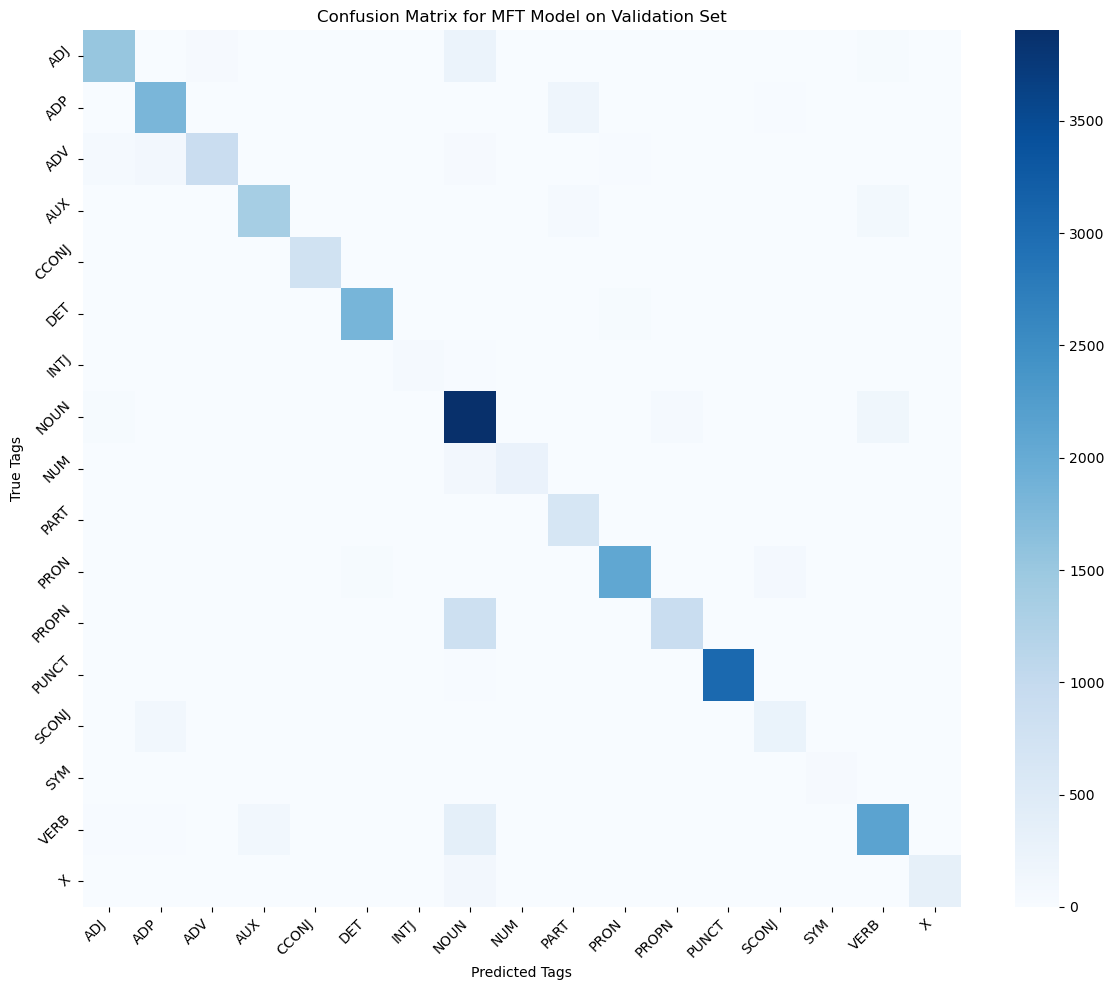

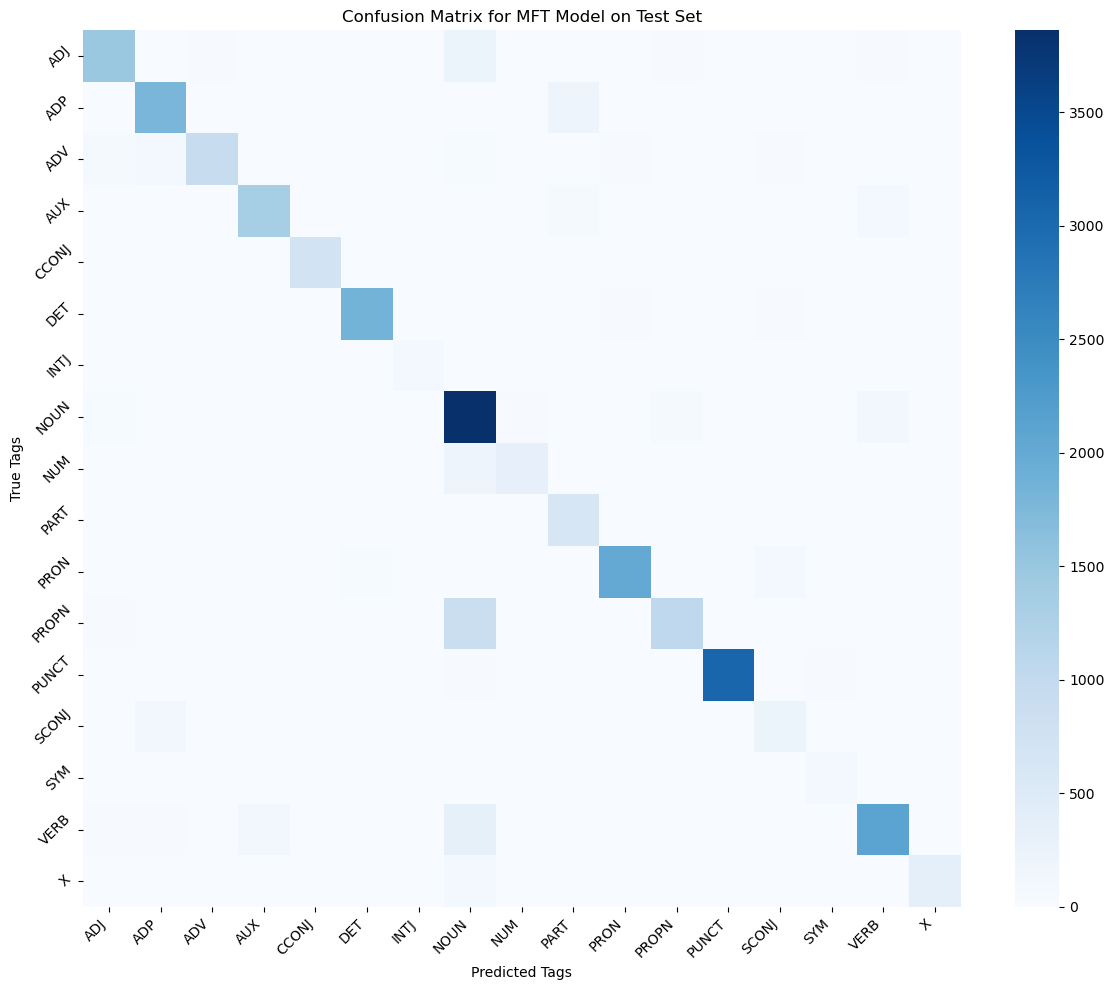

INFO - Generating Confusion Matrices for the HMM Model...


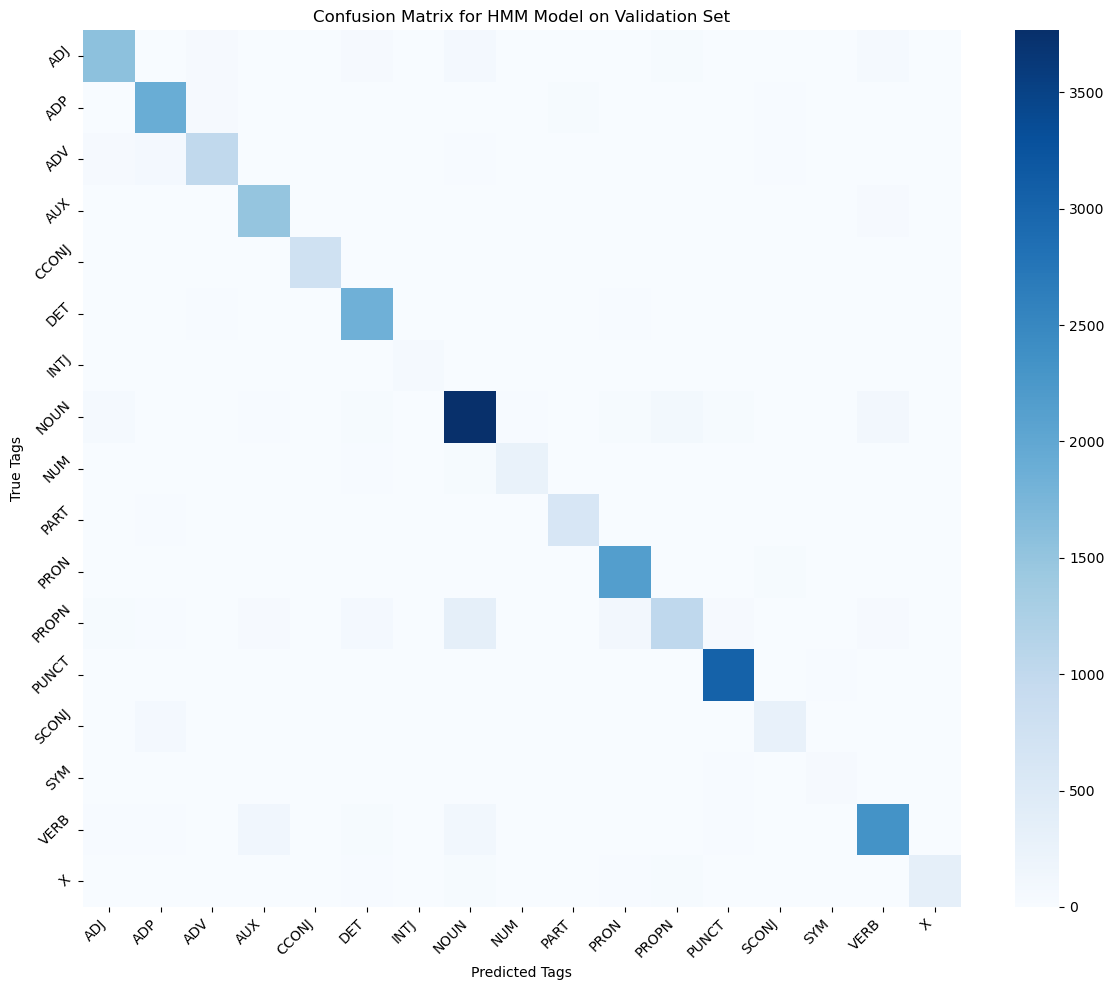

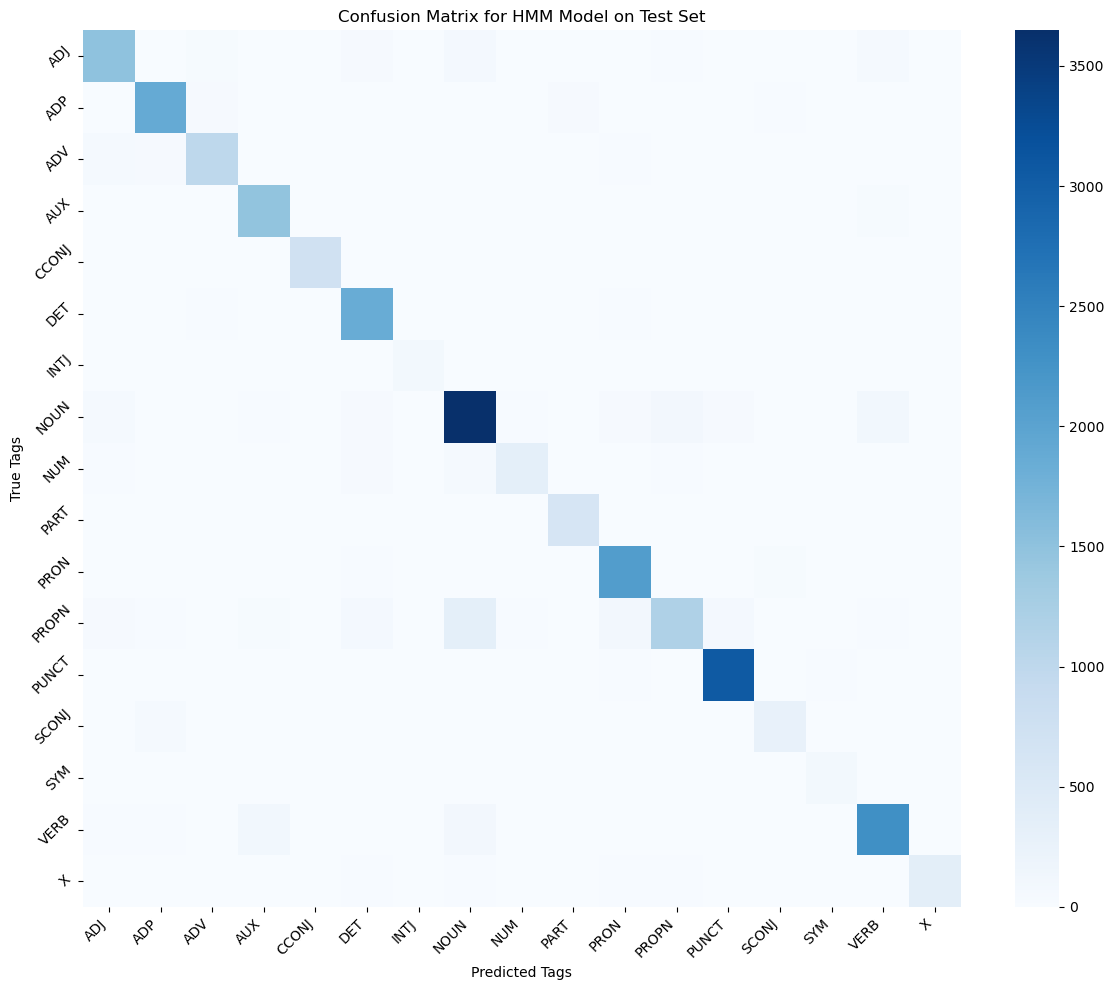

INFO - Confusion Matrix Analysis Completed Successfully.


In [10]:
# Setting up the logger for confusion matrix analysis
logger.info("Starting Confusion Matrix Analysis for MFT and HMM models...")

# 3.1.1: Function to Generate and Plot Confusion Matrix
def plot_confusion_matrix(true_tags, predicted_tags, model_name, split_name):
    """
    Generate and plot a confusion matrix as a heatmap.

    Parameters:
    - true_tags: The list of true tags.
    - predicted_tags: The list of predicted tags.
    - model_name: Name of the model being evaluated.
    - split_name: Dataset split (e.g., validation or test).
    """
    tags = sorted(set(true_tags + predicted_tags))  # Unique list of tags for consistent matrix dimensions
    cm = confusion_matrix(true_tags, predicted_tags, labels=tags)
    
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=False, cmap='Blues', xticklabels=tags, yticklabels=tags, fmt='g')
    plt.xlabel('Predicted Tags')
    plt.ylabel('True Tags')
    plt.title(f'Confusion Matrix for {model_name} Model on {split_name} Set')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=45)
    plt.tight_layout()
    plt.show()

# 3.1.2: Generating Confusion Matrix for the MFT Model
logger.info("Generating Confusion Matrices for the MFT Model...")

# Updated to skip misaligned sentences
true_tags_validation_mft = []
predicted_tags_validation_mft = []

for tokens, upos_tags in zip(df_validate['tokens'], df_validate['upos']):
    if len(tokens) == len(upos_tags):
        true_tags_validation_mft.extend(upos_tags)
        predicted_tags_validation_mft.extend(mft_tag_sentence(tokens, word_to_mft))
    else:
        logger.warning(f"Skipping misaligned validation row: tokens={len(tokens)}, tags={len(upos_tags)}")

plot_confusion_matrix(true_tags_validation_mft, predicted_tags_validation_mft, model_name="MFT", split_name="Validation")

# Test Set Confusion Matrix for MFT Model
true_tags_test_mft = []
predicted_tags_test_mft = []

for tokens, upos_tags in zip(df_test['tokens'], df_test['upos']):
    if len(tokens) == len(upos_tags):
        true_tags_test_mft.extend(upos_tags)
        predicted_tags_test_mft.extend(mft_tag_sentence(tokens, word_to_mft))
    else:
        logger.warning(f"Skipping misaligned test row: tokens={len(tokens)}, tags={len(upos_tags)}")

plot_confusion_matrix(true_tags_test_mft, predicted_tags_test_mft, model_name="MFT", split_name="Test")

# 3.1.3: Generating Confusion Matrix for the HMM Model
logger.info("Generating Confusion Matrices for the HMM Model...")

# Evaluating HMM Model on Validation Set
true_tags_validation_hmm = []
predicted_tags_validation_hmm = []

for tokens, upos_tags in zip(df_validate['tokens'], df_validate['upos']):
    if len(tokens) == len(upos_tags):
        predicted_tags = viterbi_algorithm(tokens, list(initial_probs.keys()), initial_probs, transition_probs, emission_probs)
        true_tags_validation_hmm.extend(upos_tags)
        predicted_tags_validation_hmm.extend(predicted_tags)
    else:
        logger.warning(f"Skipping misaligned validation row for HMM: tokens={len(tokens)}, tags={len(upos_tags)}")

plot_confusion_matrix(true_tags_validation_hmm, predicted_tags_validation_hmm, model_name="HMM", split_name="Validation")

# Evaluating HMM Model on Test Set
true_tags_test_hmm = []
predicted_tags_test_hmm = []

for tokens, upos_tags in zip(df_test['tokens'], df_test['upos']):
    if len(tokens) == len(upos_tags):
        predicted_tags = viterbi_algorithm(tokens, list(initial_probs.keys()), initial_probs, transition_probs, emission_probs)
        true_tags_test_hmm.extend(upos_tags)
        predicted_tags_test_hmm.extend(predicted_tags)
    else:
        logger.warning(f"Skipping misaligned test row for HMM: tokens={len(tokens)}, tags={len(upos_tags)}")

plot_confusion_matrix(true_tags_test_hmm, predicted_tags_test_hmm, model_name="HMM", split_name="Test")

logger.info("Confusion Matrix Analysis Completed Successfully.")


### Step 3.1.4 Adding Precsision, Recall, and F1 Score Evaluation

Below is the code to extend our current evaluation to include precision, recall, and F1-score for both the MFT and HMM models.

In [11]:
from sklearn.metrics import classification_report

# Setting up the logger for generating detailed metrics
logger.info("Starting Detailed Metrics Generation for MFT and HMM models...")

# Unique set of tags from all true tags across validation and test sets for consistent reporting
all_unique_tags = sorted(set(true_tags_validation_mft + true_tags_test_mft))

# 3.1.4: Generating Classification Report for the MFT Model
logger.info("Generating Detailed Metrics for the MFT Model...")

# Validation Set Metrics for MFT Model
mft_classification_report_validation = classification_report(
    true_tags_validation_mft, 
    predicted_tags_validation_mft, 
    labels=all_unique_tags, 
    zero_division=0
)
print(f"Classification Report for MFT Model on Validation Set:\n{mft_classification_report_validation}")

# Test Set Metrics for MFT Model
mft_classification_report_test = classification_report(
    true_tags_test_mft, 
    predicted_tags_test_mft, 
    labels=all_unique_tags, 
    zero_division=0
)
print(f"Classification Report for MFT Model on Test Set:\n{mft_classification_report_test}")

# 3.1.5: Generating Classification Report for the HMM Model
logger.info("Generating Detailed Metrics for the HMM Model...")

# Validation Set Metrics for HMM Model
hmm_classification_report_validation = classification_report(
    true_tags_validation_hmm, 
    predicted_tags_validation_hmm, 
    labels=all_unique_tags, 
    zero_division=0
)
print(f"Classification Report for HMM Model on Validation Set:\n{hmm_classification_report_validation}")

# Test Set Metrics for HMM Model
hmm_classification_report_test = classification_report(
    true_tags_test_hmm, 
    predicted_tags_test_hmm, 
    labels=all_unique_tags, 
    zero_division=0
)
print(f"Classification Report for HMM Model on Test Set:\n{hmm_classification_report_test}")

# Log the successful completion of detailed metrics generation
logger.info("Detailed Metrics Generation Completed Successfully.")



INFO - Starting Detailed Metrics Generation for MFT and HMM models...
INFO - Generating Detailed Metrics for the MFT Model...
INFO - Generating Detailed Metrics for the HMM Model...


Classification Report for MFT Model on Validation Set:
              precision    recall  f1-score   support

         ADJ       0.90      0.82      0.86      1869
         ADP       0.86      0.89      0.87      2033
         ADV       0.92      0.74      0.82      1230
         AUX       0.90      0.88      0.89      1548
       CCONJ       0.99      0.99      0.99       779
         DET       0.96      0.97      0.96      1902
        INTJ       0.97      0.58      0.73       115
        NOUN       0.68      0.93      0.79      4215
         NUM       0.94      0.71      0.81       381
        PART       0.69      1.00      0.81       647
        PRON       0.96      0.94      0.95      2219
       PROPN       0.91      0.52      0.66      1785
       PUNCT       0.99      0.99      0.99      3078
       SCONJ       0.66      0.62      0.64       407
         SYM       0.82      0.74      0.78        80
        VERB       0.87      0.79      0.83      2727
           X       0.96   

INFO - Detailed Metrics Generation Completed Successfully.


Classification Report for HMM Model on Validation Set:
              precision    recall  f1-score   support

         ADJ       0.88      0.84      0.86      1869
         ADP       0.89      0.94      0.91      2033
         ADV       0.86      0.82      0.84      1230
         AUX       0.87      0.96      0.91      1548
       CCONJ       0.99      0.98      0.99       779
         DET       0.87      0.97      0.92      1902
        INTJ       0.89      0.62      0.73       115
        NOUN       0.85      0.89      0.87      4215
         NUM       0.90      0.72      0.80       381
        PART       0.90      0.95      0.92       647
        PRON       0.89      0.97      0.93      2219
       PROPN       0.83      0.57      0.68      1785
       PUNCT       0.95      0.99      0.97      3078
       SCONJ       0.76      0.69      0.73       407
         SYM       0.61      0.62      0.62        80
        VERB       0.88      0.85      0.87      2727
           X       0.97   

# **PHASE C**   -- CRF Model Training

In this phase, we introduce the Conditional Random Fields (CRF) model for Part-of-Speech (POS) tagging. The CRF model is a powerful sequence modeling technique that considers the context of the entire sequence to make predictions, making it well-suited for tasks like POS tagging.

### Step 1: Analyzing Training Data for Imbalance

In this step, we aim to determine whether our training dataset is imbalanced. This analysis will help us decide if we should include a bias term in our feature representation for the CRF model.

#### Key Information:
- **POS Tag Distribution**: We calculate the frequency of each POS tag in the training dataset.
- **Statistical Analysis**: We compute the mean, median, and standard deviation of the tag counts to understand the distribution.

Mean count: 12189.823529411764
Median count: 12336.0
Standard deviation: 9345.716507010673


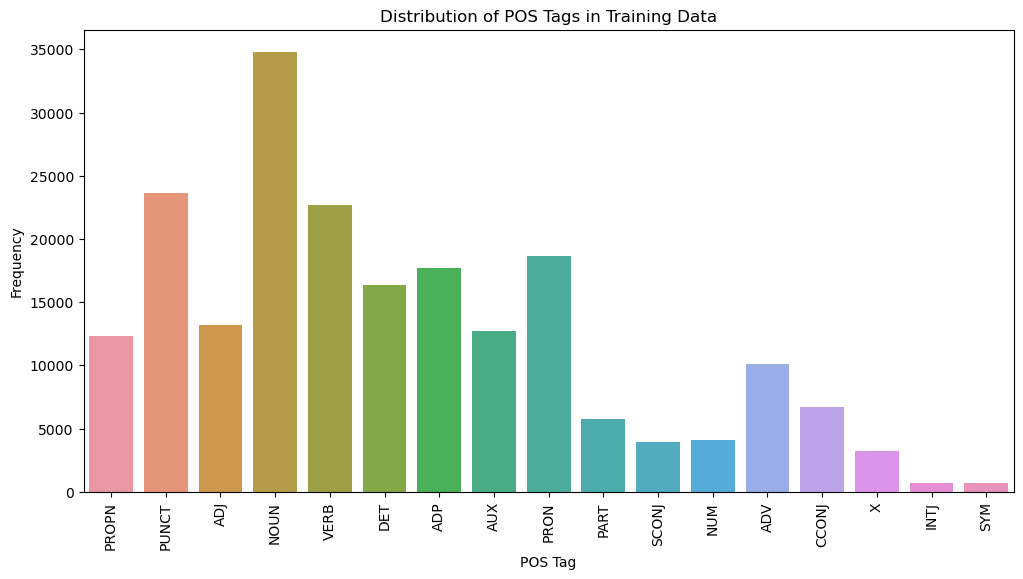

In [12]:
#Figure out key Information

#Do we need a bias?

all_tags = [tag for sentence in df_train['upos'] for tag in sentence]

# Count the frequency of each POS tag
tag_counts = Counter(all_tags)

# Convert the counts to a DataFrame for easier analysis
tag_counts_df = pd.DataFrame.from_dict(tag_counts, orient='index', columns=['count'])
tag_counts_df = tag_counts_df.reset_index().rename(columns={'index': 'tag'})

# Calculate statistics
mean_count = tag_counts_df['count'].mean()
median_count = tag_counts_df['count'].median()
std_count = tag_counts_df['count'].std()

print(f"Mean count: {mean_count}")
print(f"Median count: {median_count}")
print(f"Standard deviation: {std_count}")

# Visualize the distribution of POS tags
plt.figure(figsize=(12, 6))
sns.barplot(x='tag', y='count', data=tag_counts_df)
plt.xticks(rotation=90)
plt.title('Distribution of POS Tags in Training Data')
plt.xlabel('POS Tag')
plt.ylabel('Frequency')
plt.show()

#### Interpretation:
1. **Mean vs. Median**:
   - The mean and median counts are relatively close to each other, which suggests that the distribution is not heavily skewed. However, the difference is not negligible, indicating some level of imbalance.

2. **Standard Deviation**:
   - The standard deviation is quite high (9345.72), which indicates a significant variability in the counts of different POS tags. This suggests that some tags are much more frequent than others, leading to an imbalance.

#### Conclusion:
Given the high standard deviation, it is likely that our dataset is imbalanced, with some POS tags appearing much more frequently than others. We believe including a bias term in our model can help account for this imbalance and improve the model's performance.

#### Why Include a Bias?
- **Bias Term**: A bias term can help the model adjust for the imbalance by adding a constant value to the decision function, which can shift the predictions in favor of less frequent tags when necessary.
- **Improved Generalization**: Including a bias term can also help the model generalize better to unseen data by preventing it from being overly influenced by the most frequent tags.




### Step 2: Enhanced Feature Representation
In this step, we extract enhanced features for each word in the dataset to provide richer input to our models. These features include:

- **Basic Features**: A bias, the token itself, its lemma, and its length.
- **Contextual Features**: Previous and next tokens and their lemmas, including whether they are capitalized or is lowered.
- **Word Shape Features**: Capturing whether the token is capitalized, is lowered, contains numbers, or is punctuation.

The goal of this enhancement is to ensure that models receive contextual and syntactic information that makes predictions more accurate and less prone to ambiguity.


In [13]:
import re

# Enhanced feature extraction function
logger.info("Starting enhanced feature extraction for training split...")

def extract_features(sentence_tokens, sentence_tags=None, sentence_lemmas=None, original_features=None):
    """
    Extract features for each token in the sentence.

    Parameters:
    - sentence_tokens: List of tokens in the sentence.
    - sentence_tags: List of POS tags for the tokens.
    - sentence_lemmas: List of lemmas corresponding to the tokens.

    Returns:
    - List of dictionaries, where each dictionary represents the features for a single token.
    """
    features = []
    for idx, token in enumerate(sentence_tokens):
        original_features_dict = original_features[idx] if original_features[idx] is not None or "_" else {}
        token_features = {
            'bias': 1.0,
            'word': token,
            'lemma': sentence_lemmas[idx] if sentence_lemmas else '',
            'is_lower': token.islower(),
            'word_length': len(token),
            'contains_digit': bool(re.search(r'\d', token)),
            'is_capitalized': token[0].isupper() if token else False,
            'is_punctuation': token in string.punctuation,
            'is_url': token == '<URL>',
            'is_email': token == '<EMAIL>',
            'prefix_3': token[:3],
            'suffix_3': token[-3:],
            'original_features': original_features_dict
        }

        # Previous word features
        if idx > 0:
            token_features['prev_word'] = sentence_tokens[idx - 1]
            token_features['prev_word_lemma'] = sentence_lemmas[idx - 1] if sentence_lemmas else ''
            token_features['prev_word_is_lower'] = sentence_tokens[idx - 1].islower()
            token_features['prev_is_capitalized'] = sentence_tokens[idx - 1][0].isupper() if sentence_tokens[idx - 1] else False
        else:
            token_features['prev_word'] = '<START>'

        # Next word features
        if idx < len(sentence_tokens) - 1:
            token_features['next_word'] = sentence_tokens[idx + 1]
            token_features['next_word_lemma'] = sentence_lemmas[idx + 1] if sentence_lemmas else ''
            token_features['next_word_is_lower'] = sentence_tokens[idx + 1].islower()
            token_features['next_is_capitalized'] = sentence_tokens[idx + 1][0].isupper() if sentence_tokens[idx + 1] else False
        else:
            token_features['next_word'] = '<END>'

        features.append(token_features)

    return features

# Apply the feature extraction to all datasets and add the features directly to the DataFrames
def extract_features_for_dataset(df):
    """
    Extract features for all sentences in a dataset and add them to the DataFrame.

    Parameters:
    - df: A pandas DataFrame containing tokens, lemmas, and POS tags for the dataset.

    Returns:
    - The same DataFrame with an additional 'features' column containing the extracted features.
    """
    df['features'] = [extract_features(tokens, sentence_tags=tags, sentence_lemmas=lemmas, original_features=feats)
                      for tokens, tags, lemmas, feats in zip(df['tokens'], df['upos'], df['lemmas'], df['features'])]
    return df

# Extracting features for the training, validation, and test datasets
logger.info("Extracting features for training dataset...")
df_train = extract_features_for_dataset(df_train)
logger.info("Extracting features for validation dataset...")
df_validate = extract_features_for_dataset(df_validate)
logger.info("Extracting features for test dataset...")
df_test = extract_features_for_dataset(df_test)

# Log the successful completion of feature extraction
logger.info("Feature extraction completed successfully.")

# Show example features extracted from the training set
example_features = df_train['features'][0][0] if not df_train.empty else {}
logger.info(f"Example Features for the first token of the first sentence in the training set:\n{example_features}")


INFO - Starting enhanced feature extraction for training split...
INFO - Extracting features for training dataset...
INFO - Extracting features for validation dataset...
INFO - Extracting features for test dataset...
INFO - Feature extraction completed successfully.
INFO - Example Features for the first token of the first sentence in the training set:
{'bias': 1.0, 'word': 'Al', 'lemma': 'Al', 'is_lower': False, 'word_length': 2, 'contains_digit': False, 'is_capitalized': True, 'is_punctuation': False, 'is_url': False, 'is_email': False, 'prefix_3': 'Al', 'suffix_3': 'Al', 'original_features': {'Number': 'Sing'}, 'prev_word': '<START>', 'next_word': '-', 'next_word_lemma': '-', 'next_word_is_lower': False, 'next_is_capitalized': False}


In [14]:
import pandas as pd

# Sanity check for feature-label consistency after extraction
def verify_feature_label_alignment(df):
    """
    Verify the consistency between the number of features and labels in the dataset.

    Parameters:
    - df: A pandas DataFrame containing 'features' and 'upos' columns.

    Returns:
    - A cleaned DataFrame with consistent features and labels.
    """
    logger.info("Verifying feature-label alignment in the dataset...")
    aligned_data = []

    for idx, row in df.iterrows():
        features = row['features']
        labels = row['upos']

        # Check if the number of features matches the number of labels
        if len(features) == len(labels):
            aligned_data.append(row)
        else:
            logger.warning(f"Misalignment found at row {idx}: |features|={len(features)}, |labels|={len(labels)}. Skipping.")

    # Recreate the DataFrame with only aligned rows
    return pd.DataFrame(aligned_data)

# Apply the verification step to the training, validation, and test sets
df_train = verify_feature_label_alignment(df_train)
df_validate = verify_feature_label_alignment(df_validate)
df_test = verify_feature_label_alignment(df_test)

# Log the successful completion of verification
logger.info("Feature-label alignment verification completed successfully.")
logger.info(f"Training dataset size after verification: {len(df_train)}")
logger.info(f"Validation dataset size after verification: {len(df_validate)}")
logger.info(f"Test dataset size after verification: {len(df_test)}")


INFO - Verifying feature-label alignment in the dataset...
INFO - Verifying feature-label alignment in the dataset...
INFO - Verifying feature-label alignment in the dataset...
INFO - Feature-label alignment verification completed successfully.
INFO - Training dataset size after verification: 12544
INFO - Validation dataset size after verification: 2001
INFO - Test dataset size after verification: 2077


### Step 2: Training the CRF Model
Conditional Random Fields (CRF) are widely used for structured prediction tasks, such as Part-of-Speech (POS) tagging, because they consider the sequential nature of sentences, making predictions based on both individual token features and context from neighboring tokens.

**2.1 CRF Model Training**:
- We are using the `sklearn-crfsuite` library to train the CRF.
- We train the model using just default settings

In [15]:
from sklearn_crfsuite.metrics import flat_classification_report
import scipy.stats

# Preparing features and labels for training and validation sets
logger.info("Preparing training and validation data for CRF...")
x_train = df_train['features'].tolist()
y_train = df_train['upos'].tolist()
x_validate = df_validate['features'].tolist()
y_validate = df_validate['upos'].tolist()
x_test = df_test['features'].tolist()
y_test = df_test['upos'].tolist()

INFO - Preparing training and validation data for CRF...


**Train the model and test on the validation dataset**

In [16]:
# Setting up the CRF model on default settings
crf = CRF(max_iterations=100)

# Fit the CRF model
crf.fit(x_train, y_train)

# Evaluate the CRF model on the validation set
logger.info("Evaluating CRF model on validation set...")
y_pred_validate = crf.predict(x_validate)

print("Classification Report for CRF Model on Validation Set:")
print(flat_classification_report(y_validate, y_pred_validate, labels=sorted(set(tag for tags in y_validate for tag in tags))))


INFO - Evaluating CRF model on validation set...


Classification Report for CRF Model on Validation Set:
              precision    recall  f1-score   support

         ADJ       0.99      0.99      0.99      1869
         ADP       0.94      0.98      0.96      2033
         ADV       0.91      0.90      0.91      1230
         AUX       0.97      0.99      0.98      1548
       CCONJ       0.99      0.98      0.98       779
         DET       0.99      0.99      0.99      1902
        INTJ       0.91      0.71      0.80       115
        NOUN       0.95      0.95      0.95      4215
         NUM       0.99      1.00      0.99       381
        PART       0.98      1.00      0.99       647
        PRON       1.00      0.99      0.99      2219
       PROPN       0.87      0.88      0.88      1785
       PUNCT       0.99      1.00      0.99      3078
       SCONJ       0.91      0.85      0.88       407
         SYM       0.84      0.61      0.71        80
        VERB       0.99      0.98      0.99      2727
           X       0.98   

c:\Users\sieul\anaconda3\envs\python_3.8.20\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass labels=['ADJ', 'ADP', 'ADV', 'AUX', 'CCONJ', 'DET', 'INTJ', 'NOUN', 'NUM', 'PART', 'PRON', 'PROPN', 'PUNCT', 'SCONJ', 'SYM', 'VERB', 'X'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


**Tune the model and test on the test dataset**

Let us see if we can optimize the CRF function, so we can improve the model's performance. We attempted to run `RandomizedSearchCV` to find the best hyperparameters, but we could not successfully run it on all of our systems. Therefore, we decided to manually set the following common hyperparameters for the CRF model:

- `c1=0.1`
- `c2=0.1`
- `all_possible_transitions=True`

In [17]:
crf = CRF(
    algorithm='lbfgs',
    c1=0.1,
    c2=0.1,
    max_iterations=100,
    all_possible_transitions=True
)

# Fit the CRF model
crf.fit(x_train, y_train)

# Evaluate the optimized CRF model on the test set
logger.info("Evaluating CRF model on test set...")
y_pred_test = crf.predict(x_test)

print("Classification Report for CRF Model on Test Set:")
print(flat_classification_report(y_test, y_pred_test, labels=sorted(set(tag for tags in y_validate for tag in tags))))

INFO - Evaluating CRF model on test set...


Classification Report for CRF Model on Test Set:
              precision    recall  f1-score   support

         ADJ       0.99      1.00      1.00      1785
         ADP       0.95      0.98      0.96      2029
         ADV       0.95      0.95      0.95      1181
         AUX       0.98      0.99      0.98      1524
       CCONJ       1.00      1.00      1.00       737
         DET       1.00      1.00      1.00      1898
        INTJ       0.99      0.90      0.94       120
        NOUN       0.95      0.95      0.95      4136
         NUM       1.00      1.00      1.00       541
        PART       0.98      1.00      0.99       649
        PRON       1.00      1.00      1.00      2162
       PROPN       0.90      0.89      0.89      1981
       PUNCT       0.99      1.00      1.00      3098
       SCONJ       0.94      0.83      0.88       388
         SYM       0.90      0.82      0.86       107
        VERB       0.99      0.99      0.99      2625
           X       1.00      0.9

##### Explanation of CRF Model Arguments:

1. `algorithm='lbfgs'`:
   - **Description**: Specifies the optimization algorithm to use. `lbfgs` stands for Limited-memory Broyden–Fletcher–Goldfarb–Shanno, which is an optimization algorithm in the family of quasi-Newton methods.
   - **Usage**: It is used for finding the minimum of a function. In the context of CRF, it helps in optimizing the model parameters.

2. `c1=0.1`:
   - **Description**: Coefficient for L1 regularization. L1 regularization adds a penalty equal to the absolute value of the coefficients.
   - **Usage**: Helps in feature selection by driving some feature weights to zero, thus preventing overfitting.

3. `c2=0.1`:
   - **Description**: Coefficient for L2 regularization. L2 regularization adds a penalty equal to the square of the coefficients.
   - **Usage**: Helps in preventing overfitting by spreading the weights more evenly across features.

4. `max_iterations=100`:
   - **Description**: The maximum number of iterations for the optimization algorithm.
   - **Usage**: Limits the number of iterations to prevent the algorithm from running indefinitely.

5. `all_possible_transitions=True`:
   - **Description**: Whether to include all possible transitions between tags, even those not seen in the training data.
   - **Usage**: Ensures that the model considers all possible transitions, which can improve generalization.

**2.2 Detailed Evaluation of CRF Model - Precision, Recall, and F1 Score**:
- Once trained, the CRF model is evaluated on both validation and test sets.
- Accuracy is the primary metric used to evaluate the performance, and it is compared with our baseline models from Phase B.

While accuracy is an important metric, it doesn't always provide a complete picture, especially for POS tagging where we have multiple classes. In this step, we calculate precision, recall, and F1 score for each POS tag in order to understand the strengths and weaknesses of our CRF model more comprehensively.

- **Precision**: Measures how many of the tags predicted as a specific POS (e.g., "NOUN") were actually correct.
- **Recall**: Measures how many of the actual tags (e.g., "NOUN") were correctly identified by the model.
- **F1 Score**: Provides a harmonic mean of precision and recall, offering a balanced view of model performance.

This evaluation will help us understand where the CRF model performs well and where it may need further improvement.

INFO - Generating Classification Report for CRF Model on Test Set...


Accuracy Score: 0.9717889277435071
Classification Report for CRF Model on Test Set:
              precision    recall  f1-score   support

         ADJ       0.99      1.00      1.00      1785
         ADP       0.95      0.98      0.96      2029
         ADV       0.95      0.95      0.95      1181
         AUX       0.98      0.99      0.98      1524
       CCONJ       1.00      1.00      1.00       737
         DET       1.00      1.00      1.00      1898
        INTJ       0.99      0.90      0.94       120
        NOUN       0.95      0.95      0.95      4136
         NUM       1.00      1.00      1.00       541
        PART       0.98      1.00      0.99       649
        PRON       1.00      1.00      1.00      2162
       PROPN       0.90      0.89      0.89      1981
       PUNCT       0.99      1.00      1.00      3098
       SCONJ       0.94      0.83      0.88       388
         SYM       0.90      0.82      0.86       107
        VERB       0.99      0.99      0.99      26

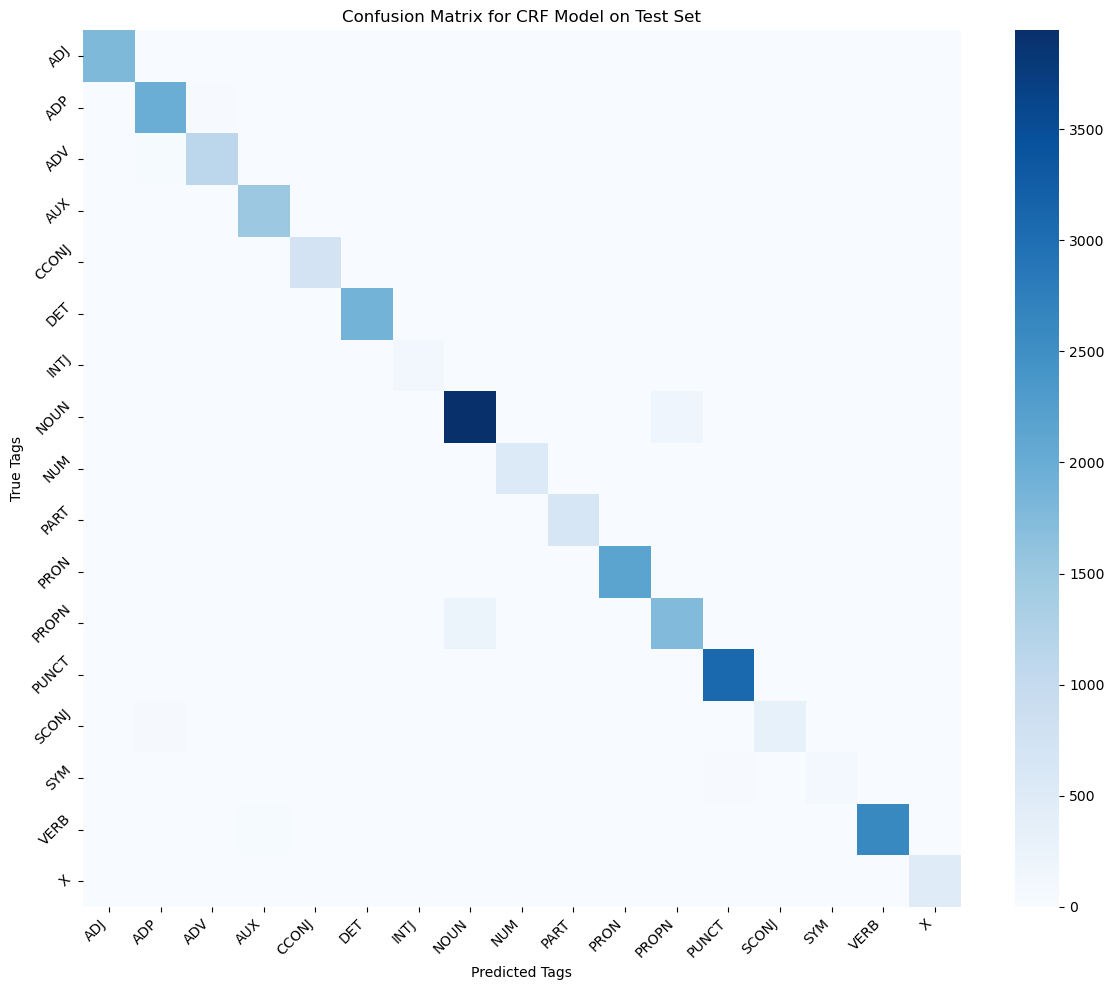

INFO - Test Set Evaluation for CRF Model Completed Successfully.


In [18]:
# Flatten the true and predicted tags for generating the classification report
test_true_tags_crf = [tag for sentence_tags in y_test for tag in sentence_tags]
test_predicted_tags_crf = [tag for sentence_tags in y_pred_test for tag in sentence_tags]

test_accuracy_crf = accuracy_score(test_true_tags_crf, test_predicted_tags_crf)
print(f"Accuracy Score: {test_accuracy_crf}")

# Generate a classification report for the CRF model on the test set
logger.info("Generating Classification Report for CRF Model on Test Set...")
crf_classification_report_test = classification_report(
    test_true_tags_crf, test_predicted_tags_crf, labels=sorted(set(test_true_tags_crf)), zero_division=0
)
print(f"Classification Report for CRF Model on Test Set:\n{crf_classification_report_test}")

# Plotting the Confusion Matrix for the CRF Model on the Test Set
plot_confusion_matrix(test_true_tags_crf, test_predicted_tags_crf, model_name="CRF", split_name="Test")

logger.info("Test Set Evaluation for CRF Model Completed Successfully.")


INFO - Generating Classification Report for CRF Model on Test Set...


Accuracy Score: 0.9642521166509878
Classification Report for CRF Model on Validation Set:
              precision    recall  f1-score   support

         ADJ       0.99      0.99      0.99      1869
         ADP       0.94      0.98      0.96      2033
         ADV       0.91      0.90      0.91      1230
         AUX       0.97      0.99      0.98      1548
       CCONJ       0.99      0.98      0.98       779
         DET       0.99      0.99      0.99      1902
        INTJ       0.91      0.71      0.80       115
        NOUN       0.95      0.95      0.95      4215
         NUM       0.99      1.00      0.99       381
        PART       0.98      1.00      0.99       647
        PRON       1.00      0.99      0.99      2219
       PROPN       0.87      0.88      0.88      1785
       PUNCT       0.99      1.00      0.99      3078
       SCONJ       0.91      0.85      0.88       407
         SYM       0.84      0.61      0.71        80
        VERB       0.99      0.98      0.99  

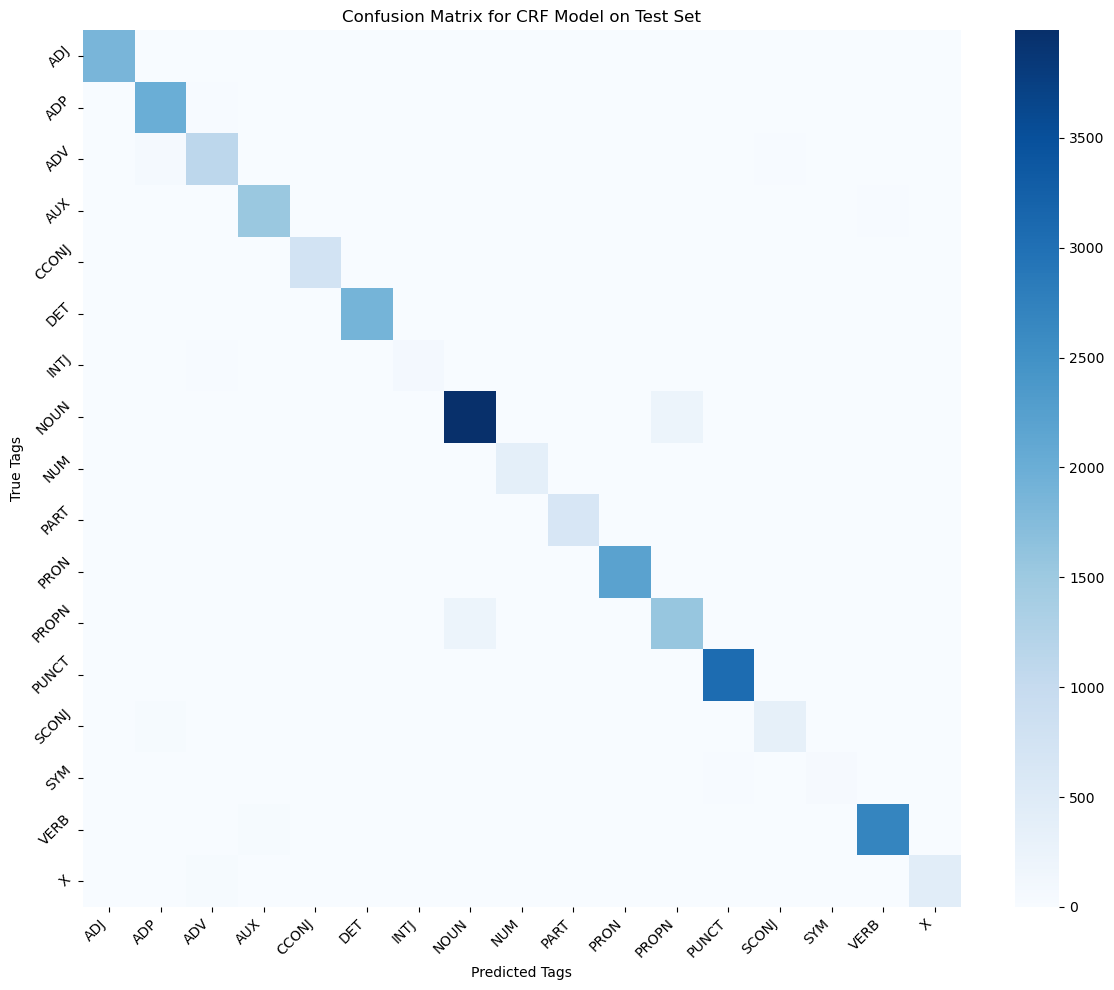

INFO - Validation Set Evaluation for CRF Model Completed Successfully.


In [19]:
# Flatten the true and predicted tags for generating the classification report
validated_true_tags_crf = [tag for sentence_tags in y_validate for tag in sentence_tags]
validated_predicted_tags_crf = [tag for sentence_tags in y_pred_validate for tag in sentence_tags]

validated_accuracy_crf = accuracy_score(validated_true_tags_crf, validated_predicted_tags_crf)
print(f"Accuracy Score: {validated_accuracy_crf}")

# Generate a classification report for the CRF model on the test set
logger.info("Generating Classification Report for CRF Model on Test Set...")
crf_classification_report_validated = classification_report(
    validated_true_tags_crf, validated_predicted_tags_crf, labels=sorted(set(validated_true_tags_crf)), zero_division=0
)
print(f"Classification Report for CRF Model on Validation Set:\n{crf_classification_report_validated}")

# Plotting the Confusion Matrix for the CRF Model on the Test Set
plot_confusion_matrix(validated_true_tags_crf, validated_predicted_tags_crf, model_name="CRF", split_name="Test")

logger.info("Validation Set Evaluation for CRF Model Completed Successfully.")


# **PHASE D**

## Step D1: Model Performance Analysis

In this phase, we will analyze the performance of our POS tagging models, including the Most Frequent Tag (MFT) model, Hidden Markov Model (HMM), and Conditional Random Fields (CRF) model. We will compare their accuracies, precision, recall, and F1 scores to draw meaningful conclusions about their effectiveness.

### D1.1: Accuracy Comparison

We will start by comparing the accuracy of each model on the validation and test datasets.


In [20]:
# Print the results for the MFT, HMM, and CRF models
print(f"MFT Model:")
print(f"\tValidation Accuracy: {mft_validation_accuracy}")
print(f"\tTest Accuracy: {mft_test_accuracy}\n")

print(f"HMM Model:")
print(f"\tValidation Accuracy: {hmm_validation_accuracy}")
print(f"\tTest Accuracy: {hmm_test_accuracy}\n")

print(f"CRF Model:")
print(f"\tValidation Accuracy on default crf model: {validated_accuracy_crf}")
print(f"\tTest Accuracy on tuned crf model: {test_accuracy_crf}")

MFT Model:
	Validation Accuracy: 0.8607322044528065
	Test Accuracy: 0.8625987191073042

HMM Model:
	Validation Accuracy: 0.8826826591407965
	Test Accuracy: 0.8859769753644258

CRF Model:
	Validation Accuracy on default crf model: 0.9642521166509878
	Test Accuracy on tuned crf model: 0.9717889277435071


### D1.2: Precision, Recall, and F1 Score

We will also evaluate the precision, recall, and F1 score for each model to understand their performance in more detail.

In [21]:
# Print classification reports for each model

# MFT Model
print("MFT Model - Validation Set Classification Report:")
print(mft_classification_report_validation)
print("\nMFT Model - Test Set Classification Report:")
print(mft_classification_report_test)

# HMM Model
print("\nHMM Model - Validation Set Classification Report:")
print(hmm_classification_report_validation)
print("\nHMM Model - Test Set Classification Report:")
print(hmm_classification_report_test)

# CRF Model
print("\nDefault CRF Model - Validation Set Classification Report:")
print(crf_classification_report_validated)
print("\nTuned CRF Model - Test Set Classification Report:")
print(crf_classification_report_test)

MFT Model - Validation Set Classification Report:
              precision    recall  f1-score   support

         ADJ       0.90      0.82      0.86      1869
         ADP       0.86      0.89      0.87      2033
         ADV       0.92      0.74      0.82      1230
         AUX       0.90      0.88      0.89      1548
       CCONJ       0.99      0.99      0.99       779
         DET       0.96      0.97      0.96      1902
        INTJ       0.97      0.58      0.73       115
        NOUN       0.68      0.93      0.79      4215
         NUM       0.94      0.71      0.81       381
        PART       0.69      1.00      0.81       647
        PRON       0.96      0.94      0.95      2219
       PROPN       0.91      0.52      0.66      1785
       PUNCT       0.99      0.99      0.99      3078
       SCONJ       0.66      0.62      0.64       407
         SYM       0.82      0.74      0.78        80
        VERB       0.87      0.79      0.83      2727
           X       0.96      0.

### Phase D1.3: Confusion Matrices and Line Plot Analysis


#### Line Plot of Evaluation Metrics
We generated a line plot to compare the **accuracy** and **macro F1 scores** for each model on both the validation and test sets:

- **Blue lines** represent **accuracy** for the validation and test sets.
- **Green lines** represent **macro F1 scores** for the validation and test sets.

This plot helps compare the three models — MFT, HMM, and CRF — and highlights:

- **CRF Model** consistently outperforms the other models for both metrics.
- **HMM Model** shows better performance than the MFT model, but not as high as the CRF model.
- **MFT Model** lags behind, as expected, due to its simplistic strategy of tagging based on the most frequent word-tag pair.

#### Key Observations
- **CRF Outperforms Other Models**: The **CRF Model** achieves the highest **accuracy** and **macro F1 scores**, proving its capability in handling complex tagging relationships.
- **Metric Consistency**: The validation and test metrics are consistent, showing no significant overfitting for any of the models.
- **Macro F1 Score Gaps**: Lower **macro F1 scores** for the MFT model indicate a challenge in handling less common tags effectively, unlike the HMM and CRF models.


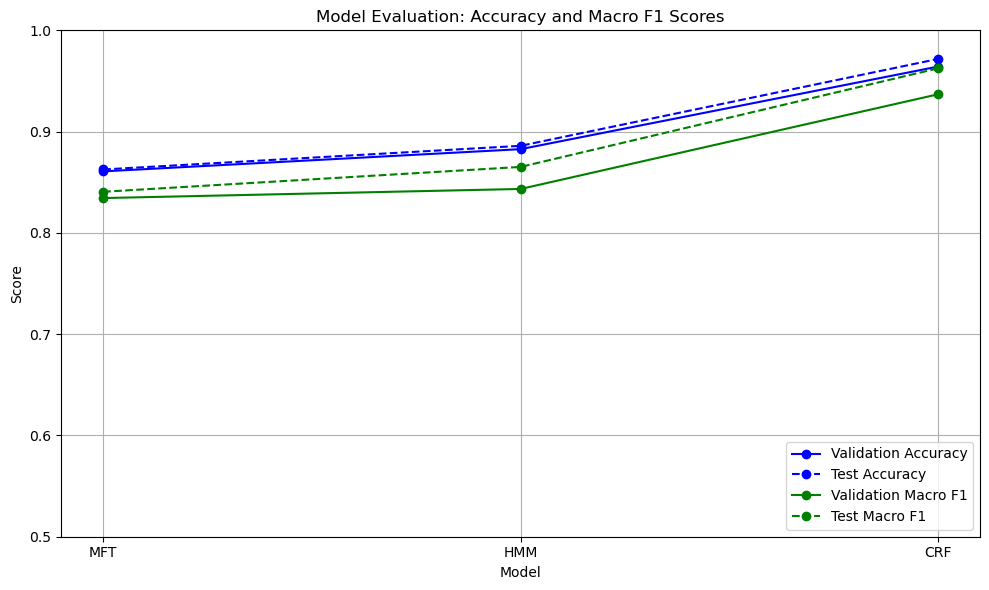

In [22]:
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

# Assuming you still have the true and predicted tags for each model

# Generate the classification reports again as dictionaries
mft_classification_report_validation = classification_report(true_tags_validation_mft, predicted_tags_validation_mft, output_dict=True, zero_division=0)
mft_classification_report_test = classification_report(true_tags_test_mft, predicted_tags_test_mft, output_dict=True, zero_division=0)

hmm_classification_report_validation = classification_report(true_tags_validation_hmm, predicted_tags_validation_hmm, output_dict=True, zero_division=0)
hmm_classification_report_test = classification_report(true_tags_test_hmm, predicted_tags_test_hmm, output_dict=True, zero_division=0)

crf_classification_report_validation = classification_report(validated_true_tags_crf, validated_predicted_tags_crf, output_dict=True, zero_division=0)
crf_classification_report_test = classification_report(test_true_tags_crf, test_predicted_tags_crf, output_dict=True, zero_division=0)

# Model Names
model_names = ['MFT', 'HMM', 'CRF']

# Extracting accuracy and macro F1 scores
validation_accuracy = [
    mft_classification_report_validation['accuracy'],
    hmm_classification_report_validation['accuracy'],
    crf_classification_report_validation['accuracy']
]

test_accuracy = [
    mft_classification_report_test['accuracy'],
    hmm_classification_report_test['accuracy'],
    crf_classification_report_test['accuracy']
]

validation_macro_f1 = [
    mft_classification_report_validation['macro avg']['f1-score'],
    hmm_classification_report_validation['macro avg']['f1-score'],
    crf_classification_report_validation['macro avg']['f1-score']
]

test_macro_f1 = [
    mft_classification_report_test['macro avg']['f1-score'],
    hmm_classification_report_test['macro avg']['f1-score'],
    crf_classification_report_test['macro avg']['f1-score']
]

# Plotting
plt.figure(figsize=(10, 6))

# Accuracy Plots
plt.plot(model_names, validation_accuracy, marker='o', linestyle='-', label='Validation Accuracy', color='blue')
plt.plot(model_names, test_accuracy, marker='o', linestyle='--', label='Test Accuracy', color='blue')

# Macro F1 Score Plots
plt.plot(model_names, validation_macro_f1, marker='o', linestyle='-', label='Validation Macro F1', color='green')
plt.plot(model_names, test_macro_f1, marker='o', linestyle='--', label='Test Macro F1', color='green')

# Chart Settings
plt.title('Model Evaluation: Accuracy and Macro F1 Scores')
plt.xlabel('Model')
plt.ylabel('Score')
plt.ylim([0.5, 1.0])  # Adjust Y-axis to focus on the range of values observed
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()

# Show the Plot
plt.show()


### D1.4: Confusion Matrix Analysis

Confusion matrices provide a detailed visualization of the model's predictions against the true labels, allowing us to see where misclassifications are occurring. We generated confusion matrices for the following models and dataset splits:

- **MFT Model** on Validation and Test Sets
- **HMM Model** on Validation and Test Sets
- **CRF Model** on Validation and Test Sets

The confusion matrices show that the **CRF Model** achieved the highest performance with minimal misclassifications. The matrices reveal strong diagonal dominance, which indicates effective tagging across most categories.

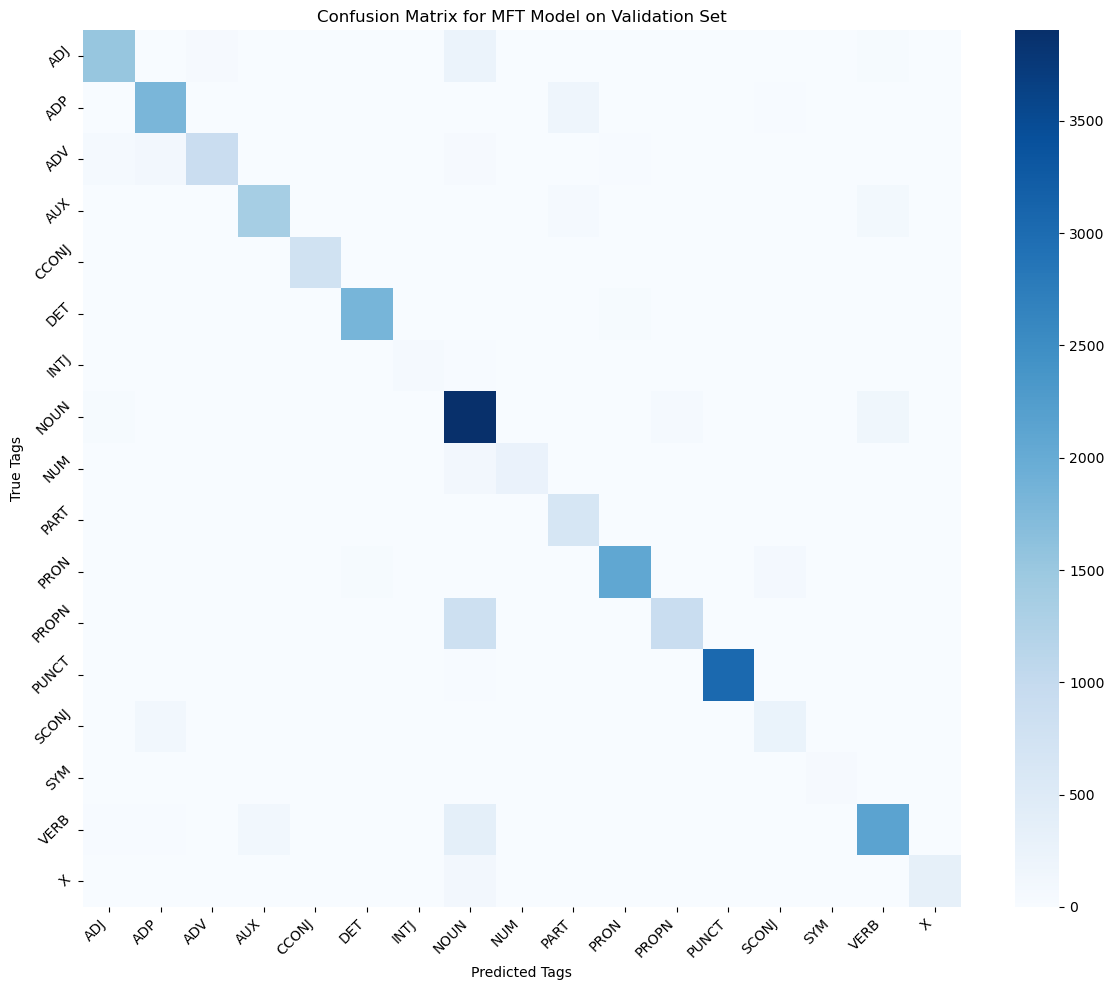

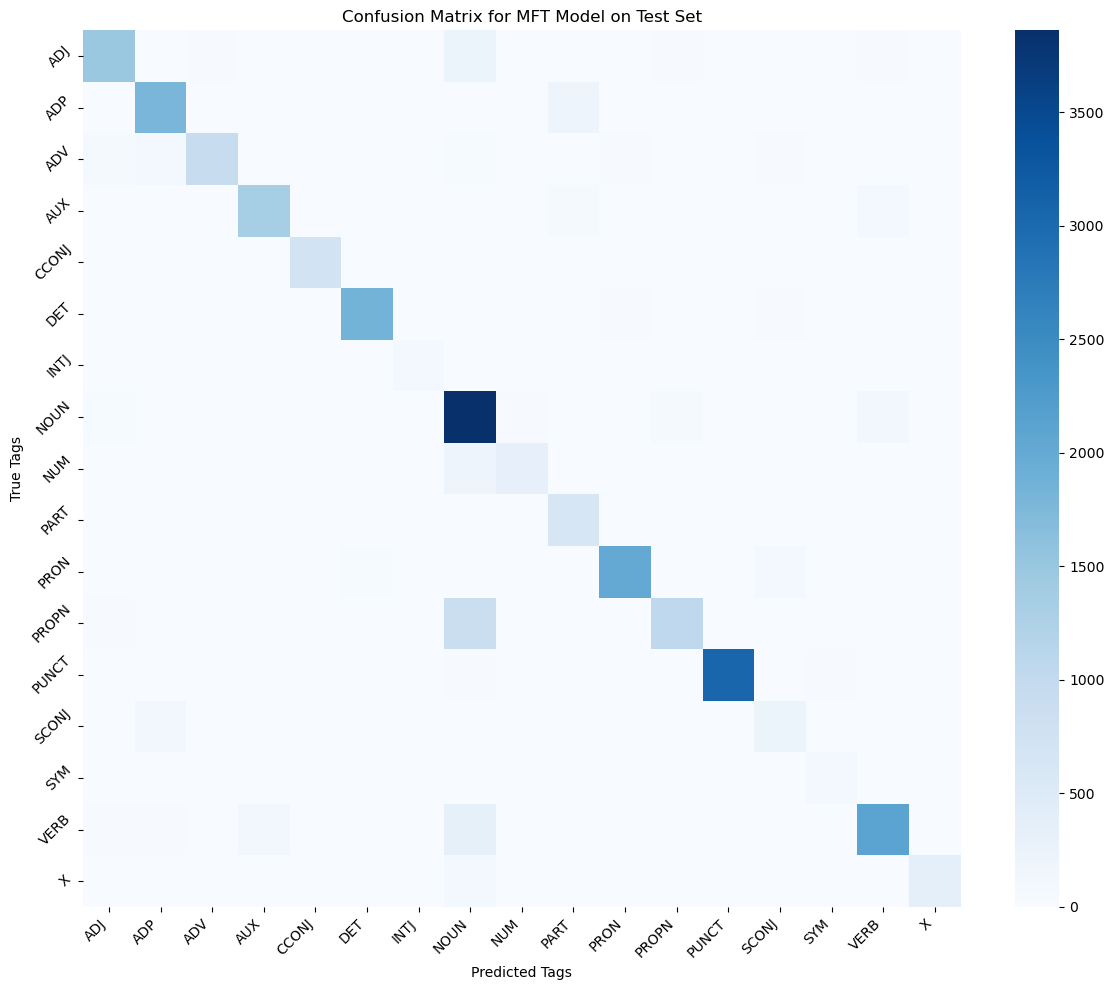

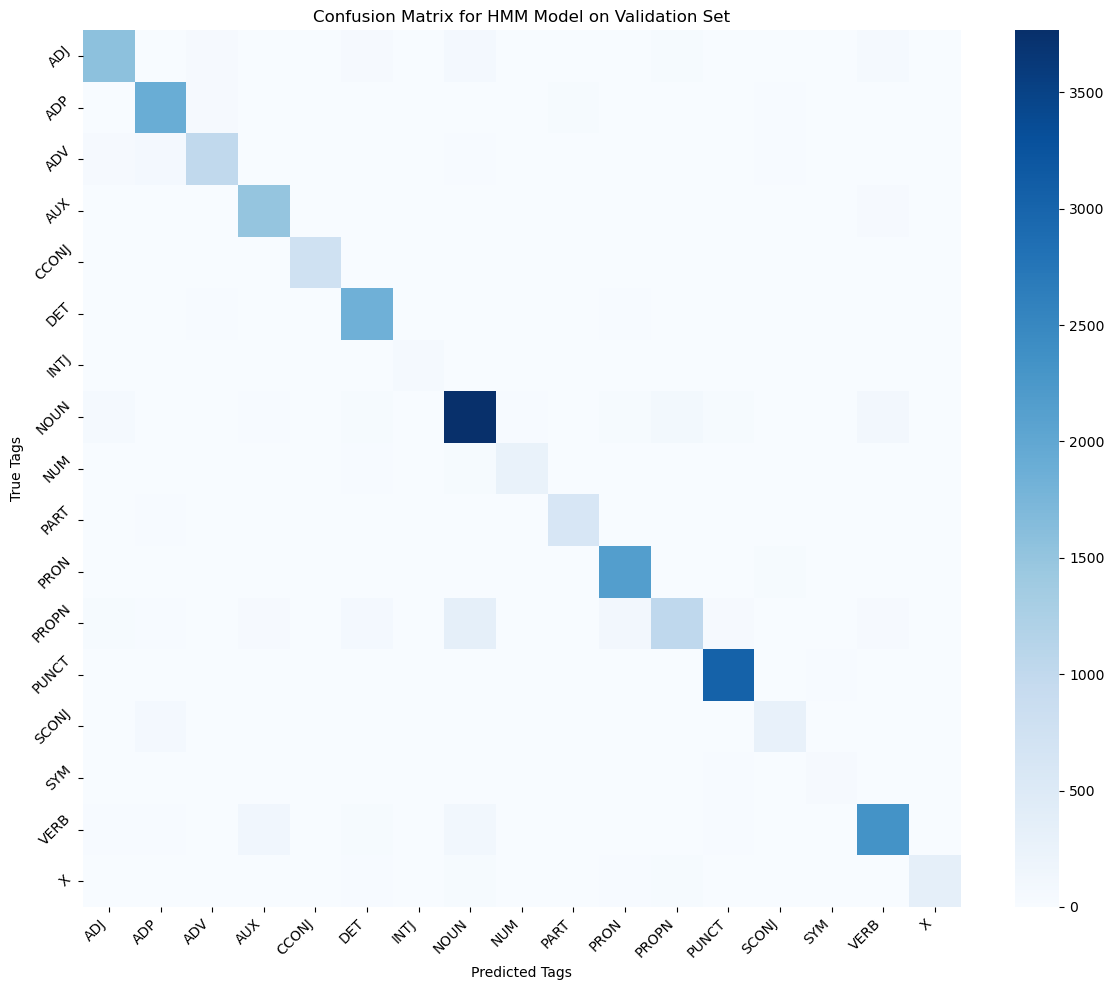

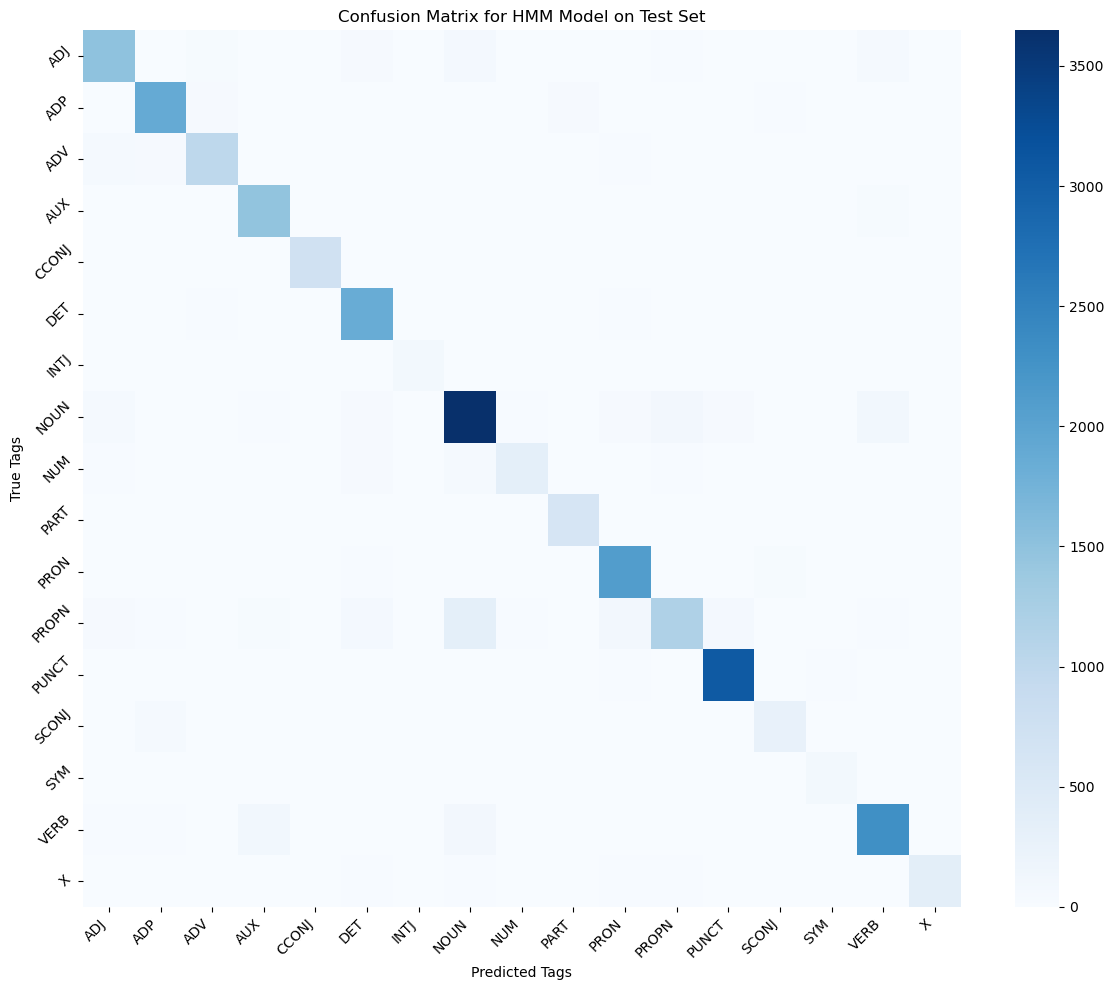

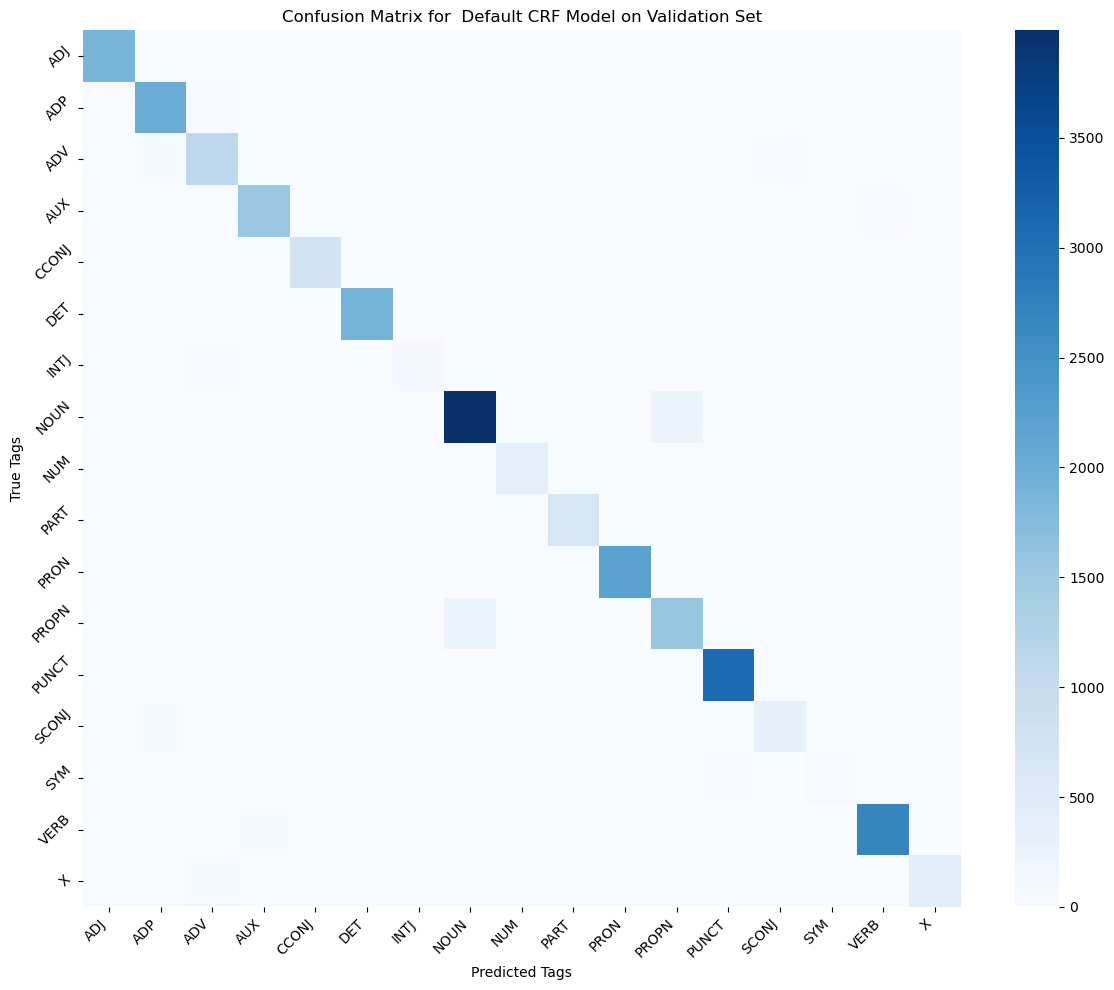

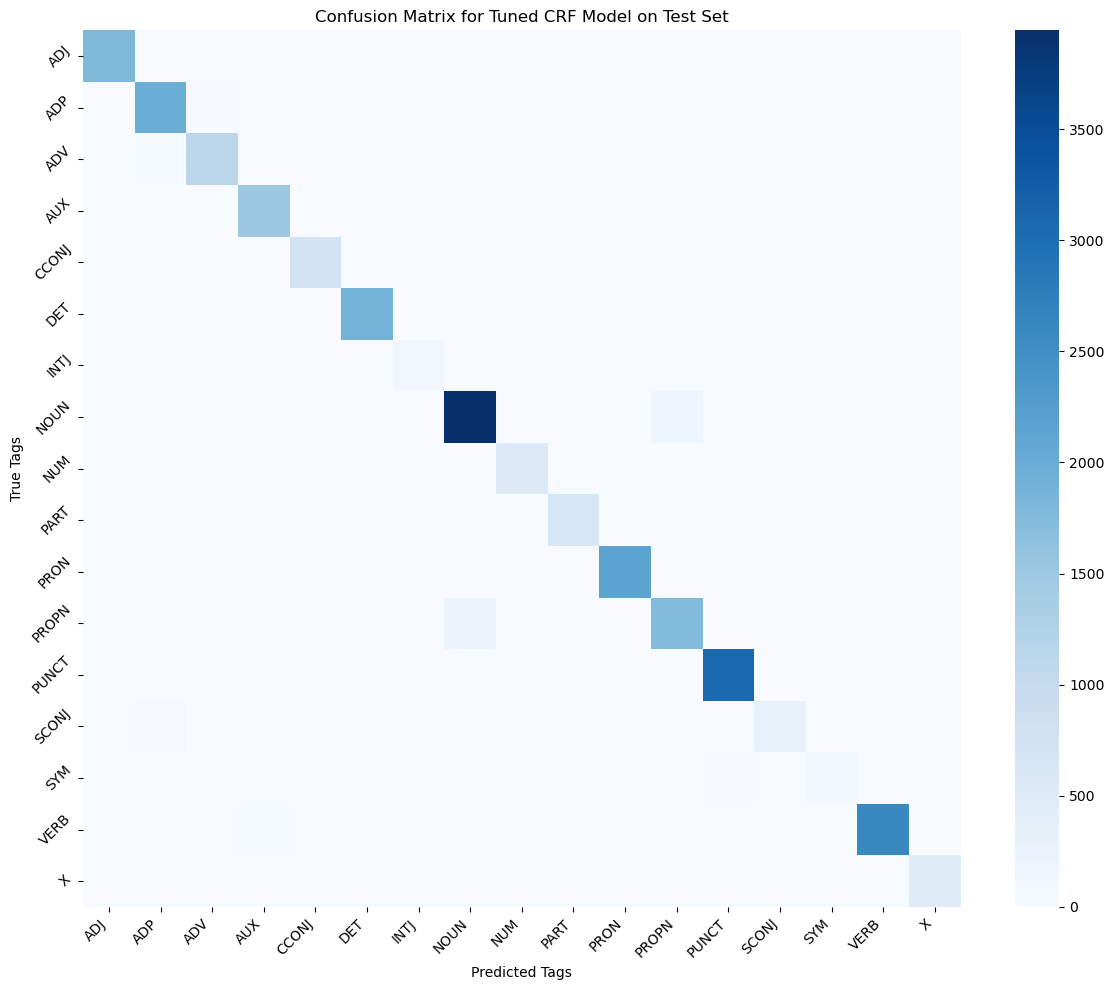

In [23]:
# Plotting confusion matrices for different models and splits

# MFT Model - Validation Set
plot_confusion_matrix(true_tags_validation_mft, predicted_tags_validation_mft, model_name="MFT", split_name="Validation")

# MFT Model - Test Set
plot_confusion_matrix(true_tags_test_mft, predicted_tags_test_mft, model_name="MFT", split_name="Test")

# HMM Model - Validation Set
plot_confusion_matrix(true_tags_validation_hmm, predicted_tags_validation_hmm, model_name="HMM", split_name="Validation")

# HMM Model - Test Set
plot_confusion_matrix(true_tags_test_hmm, predicted_tags_test_hmm, model_name="HMM", split_name="Test")

# CRF Model - Validation Set
plot_confusion_matrix(validated_true_tags_crf, validated_predicted_tags_crf, model_name=" Default CRF", split_name="Validation")

# CRF Model - Test Set
plot_confusion_matrix(test_true_tags_crf, test_predicted_tags_crf, model_name="Tuned CRF", split_name="Test")


### D1.4: Conclusion

Based on the analysis, we will draw conclusions about the strengths and weaknesses of each model and suggest potential improvements for future work.

Based on the analysis, we can draw the following conclusions:

- **Most Frequent Tag (MFT) Model**:
    - **Strengths**: The MFT model is simple and provides a strong baseline for common words in the training set.
    - **Weaknesses**: It struggles with out-of-vocabulary words and lacks context awareness, leading to lower accuracy compared to more advanced models.

- **Hidden Markov Model (HMM)**:
    - **Strengths**: The HMM model improves over the MFT by considering the sequence of words, leading to better performance, especially for tags that depend on context.
    - **Weaknesses**: It still has limitations in capturing long-range dependencies and may not perform well on rare tags.

- **Conditional Random Fields (CRF) Model**:
    - **Strengths**: The CRF model achieves the highest accuracy by leveraging rich feature representations and considering the entire sequence context. It performs well across all tags, including rare ones, although there are occasional misclassifications between pronouns and nouns.
    - **Weaknesses**: The CRF model is more complex and computationally intensive, requiring more resources for training and inference.